# IFT6512 - Projet final

In this notebook, we will implement a stochastic optimization problem using the concept of importance sampling for Monte Carlo approaches, introduced by George B. Dantzig and Peter W. Glynn in their 1990 paper, [Parallel Processors for Planning Under Uncertainty](https://link.springer.com/article/10.1007/BF02023045). We will apply this technique to an electricity production planning problem, using [open data](https://www.hydroquebec.com/documents-donnees/donnees-ouvertes/historique-production-consommation/) from Hydro-Québec, the province of Quebec's state-owned electricity producer and distributor.  

Unlike previous assignments for this class, this work will be completed using Python rather than Julia.  

**Software versions:**  

- Python: 3.9.5  
- Packages:
    - General utilities:
        - `sys`, `os`: same as Python
        - `matplotlib`: 3.5.0 $\rightarrow$ for visualizations
        - `tqdm`: 4.61.2 $\rightarrow$ to show a progress bar during long processes
    - Numerical and scientific functions:
        - `numpy`: 1.21.2
        - `scipy`: 1.7.1
    - Data handling:
        - `pandas`: 1.3.4
        - `json`: 2.0.9
        - `urllib.request`: 3.9  
        - `openpyxl`: 3.0.9
    - Modeling utilities:
        - `sklearn`: 1.0.1

In [1]:
import sys, json, openpyxl, os
import numpy as np
import scipy as sp
import scipy.stats as sps
from scipy.optimize import root_scalar
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

YEARS = [2018, 2019, 2020]

## Loading the data

First, we load the Hydro-Québec data. We will take locally-saved files that have been modified to correct a formula mistake (in the originals, I noticed inconsistent definitions and applications of the formula for column `L` of the sheets named `2-Proxy horaire`, which I standardized as `max(0, K-J)`).

In [2]:
#hydroqc_root_source = "https://www.hydroquebec.com/data/documents-donnees/xls/"
hydroqc_root_source = "data/"
hydroqc_data_sources = {
    2018: hydroqc_root_source + "suivi-2018-entente-globale-cadre-1mai2019.xlsx",
    2019: hydroqc_root_source + "suivi-2019-entente-globale-cadre-mai2020.xlsx",
    2020: hydroqc_root_source + "suivi-2020-entente-globale-cadre-mai2021.xlsx"
}
hydroqc_data_tab = "2-Proxy horaire"

# Load the data in dictionary indexed by year
hydroqc_data = {
    yr: pd.read_excel(hydroqc_data_sources[yr],
                      sheet_name = hydroqc_data_tab,
                      index_col = 0)
    for yr in YEARS
}
print("Data loaded.")

# Change long column names into shorter and more convenient names
drop = [
    "Différence des dépassement entre la méthode Entente cadre et Proxy (MWh)",
    "Dépassements calculés selon le calcul de l'entente-cadre (MWh)"
]
net_req_key = "Proxi pour évaluer le volume d'électricité mobilisée par le"
net_req_key += " Distributeur au titre d'électricité patrimoniale (MWh)"
excess_key = "Volume d'électricité mobilisée par le Distributeur en dépassement de "
excess_key += "l'électricité patrimoniale (MWh)"
rename = {
    "Mois": 
        "month",
    "Jour": 
        "day",
    "Heure":
        "hour",
    "BRD_RI (MWh)":
        "req_total",
    "Achats long terme + Électricité Interruptible (MWh)":
        "LT_purchases",
    "Achats court terme (MWh)": 
        "ST_purchases",
    "Achats court terme":
        "ST_purchases",
    "Prix moyen des achats court terme ($/MWh)": 
        "ST_purchases_unit_cost",
    "BRD_RI (HQP) (MWh)": 
        "req_production_gross",
    "Consommation des centrales (MWh)": 
        "req_production_own_use",
    net_req_key: 
        "req_production_net",
    "Volume d'électricité patrimoniale (bâtonnets affectés) (MWh)":
        "act_production_net",    
    excess_key: 
        "excess",
    "Coût unitaire du dépassement  ($/MWh)": 
        "unit_cost_excess",
    "(DAM HQ + TSC NYPA-HQ + NTAC + SC NYISO) * T ($/MWh)":
        "mystery_unit_price",
    "Coût total horaire ($)": 
        "total_cost_excess"
}

for y in YEARS:
    data = hydroqc_data[y]
    
    try:
        data = data.drop(drop, axis=1)
    except Exception as e:
        print(y)
        for c in data.columns:
            print(c)
        raise e
    
    # Shorten and standardize column names
    try:
        data = data.rename(columns = rename)
    except Exception as e:
        print(y)
        for c in data.columns:
            print(c)
        raise e
    
    # The second row of the Excel file contains description, which is read as data
    # by Pandas. We therefore need to remove the first row of "data"
    data = data.iloc[1:]
    
    # Fix a known error in the data
    if y == 2019:
        data.at[1659, 'month'] = 3
    
    # Create index from date/time
    time_cols = ['month', 'day', 'hour', 'year']
    data = data.assign(year = y)                                # Add a "year" column
    data[time_cols] = data[time_cols].astype(int)               # Require for datetime compatibility
    data = data.assign(time = pd.to_datetime(data[time_cols]))
    data = data.set_index('time').drop(time_cols, axis=1)
    
    hydroqc_data[y] = data

data = pd.concat(list(hydroqc_data.values()), axis=0)
print("data shape:", data.shape)
data.head()

Data loaded.
data shape: (26304, 12)


,req_total,LT_purchases,ST_purchases,req_production_gross,req_production_own_use,req_production_net,act_production_net,excess,unit_cost_excess,total_cost_excess,mystery_unit_price,ST_purchases_unit_cost
time,,,,,,,,,,,,
2018-01-01 01:00:00,32910,2239.580348,400.0,30270.419652,69,30201.419652,30569.0,367.580348,300.0,110274.104407,63.92,124.340000
2018-01-01 02:00:00,32939,2217.269417,400.0,30321.730583,69,30252.730583,30585.0,332.269417,300.0,99680.825002,64.23,124.340000
2018-01-01 03:00:00,33101,2211.984978,400.0,30489.015022,69,30420.015022,30683.0,262.984978,300.0,78895.493512,54.39,124.340000
2018-01-01 04:00:00,33281,2211.919559,575.0,30494.080441,69,30425.080441,30738.0,312.919559,300.0,93875.867557,53.93,104.820891
2018-01-01 05:00:00,33619,2211.681239,575.0,30832.318761,70,30762.318761,31327.0,564.681239,300.0,169404.371827,57.12,96.309634


## Exploratory data analysis

Let us first look at the totals (in terawatthours) and the averages of unit costs/prices (in $/megawatthour):

In [3]:
# Totals in terawatthours
mask = lambda keyword: data.columns.str.contains(keyword)
print("\nTotals:\n", data.loc[:, ~mask('unit')].sum(0) / 1e6)

# Mean prices / costs per megawatthour
print("\nAverages:\n", data.loc[:, mask('unit')].mean(0))


Totals:
 req_total                  558.571699
LT_purchases                49.914363
ST_purchases                 2.844546
req_production_gross        505.81279
req_production_own_use       1.013244
req_production_net         504.799546
act_production_net         539.194573
excess                      34.395026
total_cost_excess         2646.979505
dtype: object

Averages:
 unit_cost_excess          114.398710
mystery_unit_price         32.005725
ST_purchases_unit_cost      8.378944
dtype: float64


### Demand patterns

What does the demand look like over the period we study? Let's look at the mean and standard deviations of the total demand (`req_total`), over 10-day rolling windows.

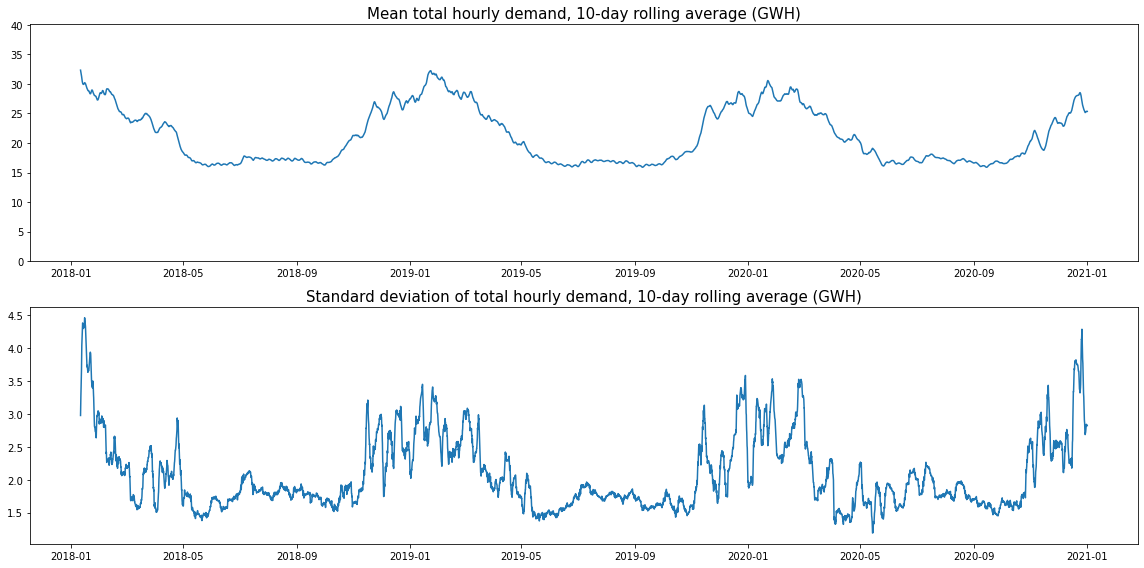

In [4]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))
window_days = 10

# Mean demand
axes[0].plot(data['req_total'].rolling(window = window_days*24).mean() / 1e3)
axes[0].set_ylim([0, data['req_total'].max() * 1.05 / 1e3])
axes[0].set_title("Mean total hourly demand, {}-day rolling average (GWH)".format(window_days), 
                  fontsize=15)

# Standard deviation of hourly demand
axes[1].plot(data['req_total'].rolling(window = window_days*24).std() / 1e3)
axes[1].set_title("Standard deviation of total hourly demand, {}-day rolling average (GWH)".format(window_days), 
                  fontsize=15)

plt.tight_layout()
plt.show()

Both the mean and volatility of demand peak during the winter months - which makes a lot of sense, since many people heat their homes (which is very energy-intensive) with electricity, and the amount of energy required to keep a certain temperature indoors can vary a lot from one day to the next if there are large swings in the temperature, as we know there are during Quebec's winters. The laws of thermodynamics also make the relationship nonlinear: if the temperature difference between indoors and out is large, thermal energy will diffuse from the warm space to the cold one faster than if the difference is small.  

To confirm this hypothesis (not really necessary, but I'm having fun...), let us plot a 2D histogram of the relation between the hourly temperature in Montreal (sourced from Environment Canada) and total hourly demand:

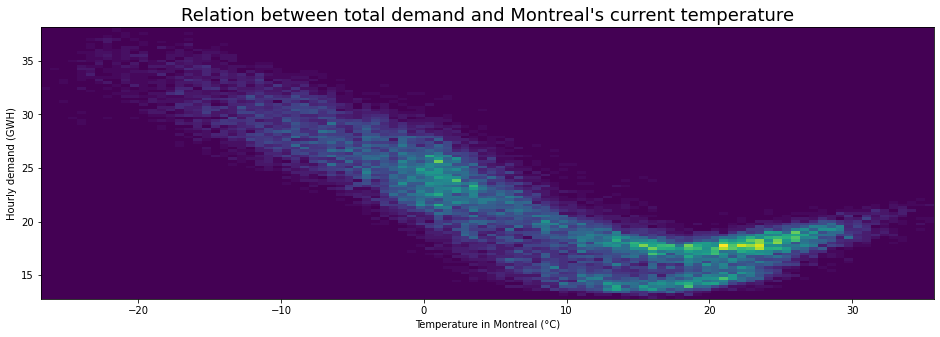

In [5]:
temperature_data_file = "data/mtl_temperature.csv"

if os.path.exists(temperature_data_file):
    comparison = pd.read_csv(temperature_data_file, index_col=0)
    comparison.index = pd.to_datetime(comparison.index)
    
else:
    URL_ENV_CAN = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID="
    URL_ENV_CAN += "30165&Year={}&Month={}&Day=1&timeframe=1"
    id_col = "Date/Time (LST)"
    temp_col = "Temp (°C)"

    temp_mtl = pd.concat([
        pd.concat([
            pd.read_csv(URL_ENV_CAN.format(y, m)).set_index(id_col).loc[:, temp_col]
            for m in range(1,13)
        ])        
        for y in YEARS    
    ])

    temp_mtl.name = "temp_mtl"
    temp_mtl.index = pd.to_datetime(temp_mtl.index)
    temp_mtl = temp_mtl.dropna().to_frame()
    comparison = temp_mtl.join(data['req_total'], how='inner')
    comparison.to_csv(temperature_data_file)
    
plt.figure(figsize=(16, 5))
plt.hist2d(comparison.temp_mtl, comparison.req_total / 1e3, bins=(100,100))
plt.xlabel("Temperature in Montreal (°C)")
plt.ylabel("Hourly demand (GWH)")
plt.title("Relation between total demand and Montreal's current temperature", fontsize=18)
plt.show()

As expected, heating interiors during the cold winter months takes a LOT of energy; we also notice a slight upward slope when temperatures rise above 20°C, probably due to the consumption of air conditioning units.

Let us now group the hours of the day together and compare them across the dataset, over 24-hour cycles:

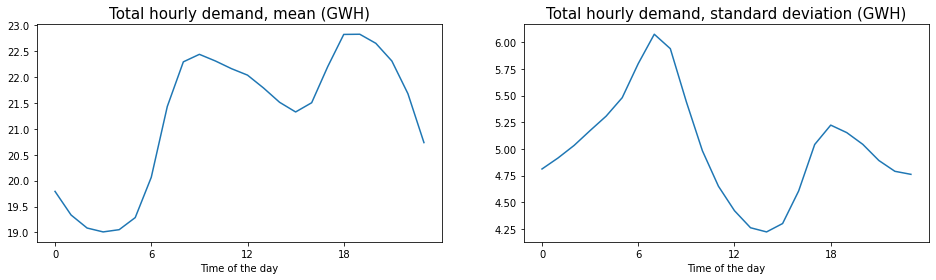

In [6]:
daily = data.groupby(data.index.hour).req_total.agg([np.mean, np.std])
daily.columns = ["avg", "stdev"]
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
plots = [daily.avg, daily.stdev]
titles = ["Total hourly demand, mean (GWH)", "Total hourly demand, standard deviation (GWH)"]
for i in [0,1]:
    axes[i].plot(plots[i] / 1e3)
    axes[i].set_title(titles[i], fontsize=15)
    axes[i].set_xlabel("Time of the day")
    axes[i].set_xticks([0, 6, 12, 18])
plt.show()

These last two graphs are aggregates, and might mask significant variability. If we compare the standard deviation of total hourly demand over varying windows, what do these distributions look like?

(26304, 23)


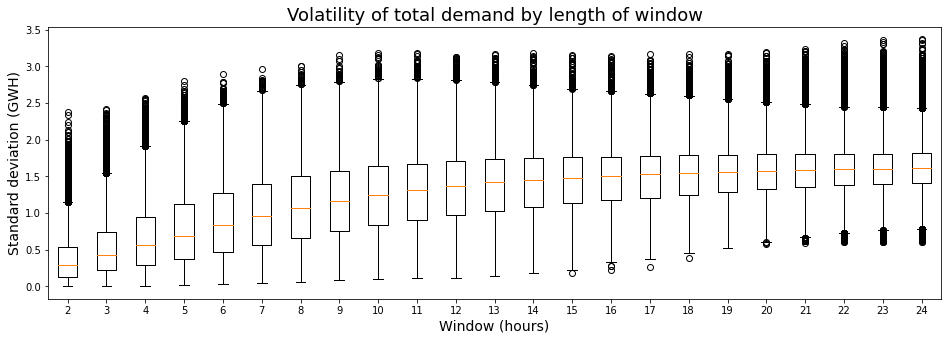

In [7]:
stats = np.zeros((data.shape[0], 23))
for w in range(2,25):
    stats[:, w-2] = data['req_total'].rolling(window=w).std().to_numpy() / 1e3
    
print(stats.shape)
plt.figure(figsize=(16,5))
plt.boxplot(stats[~np.isnan(stats).any(1)],
            labels = range(2,25))
plt.title("Volatility of total demand by length of window", fontsize=18)
plt.xlabel("Window (hours)", fontsize=14)
plt.ylabel("Standard deviation (GWH)", fontsize=14)
plt.show()

How much does demand vary, from one hour to the next?

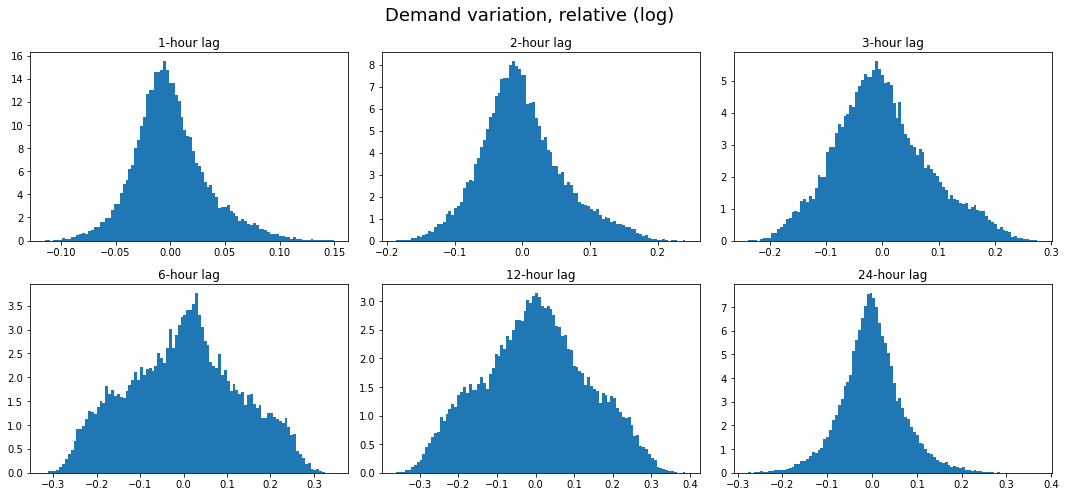

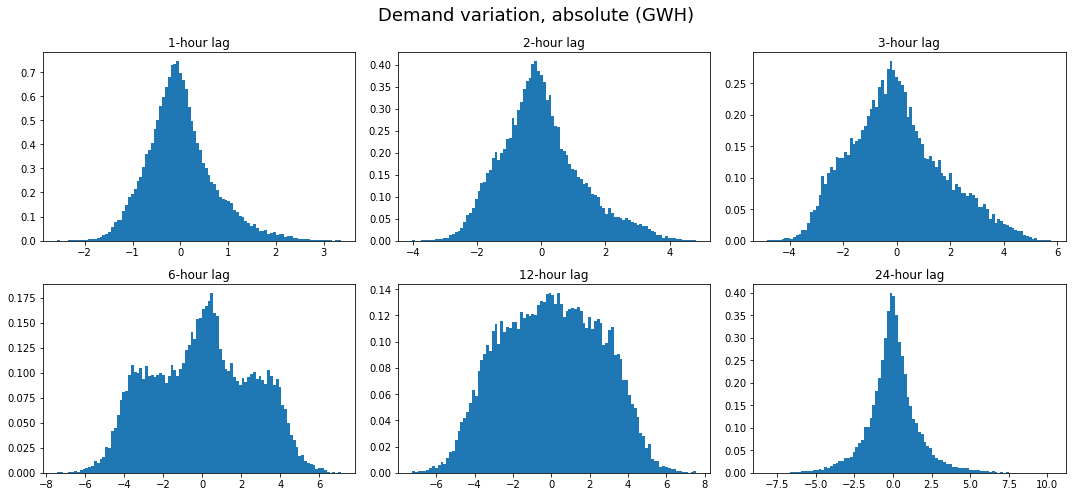

In [8]:
lags = [1, 2, 3, 6, 12, 24]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 7))
for i in range(6):
    ax = axes[i // 3, i % 3]
    ax.hist(np.log(data.req_total.pct_change(periods=lags[i]) + 1), bins=100, density=True)
    ax.set_title("{}-hour lag".format(lags[i]))
plt.suptitle("Demand variation, relative (log)", fontsize=18)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 7))
for i in range(6):
    ax = axes[i // 3, i % 3]
    ax.hist(data.req_total.diff(periods=lags[i]) / 1e3, bins=100, density=True)
    ax.set_title("{}-hour lag".format(lags[i]))
plt.suptitle("Demand variation, absolute (GWH)", fontsize=18)
plt.tight_layout()
plt.show()

Two things stand out from these graphs:  
1. Demand swings can be extremely quick: the upper tail of the 1-hour absolute variations histogram tops 3 *gigawatts*. That's a lot of electricity!!
2. 12-hour and 24-lags have very different distributions, which makes sense: 12-hour lags will often be between daytime and nighttime, between which the temperature will typically change more than between a given hour one day and the same hour the following day.

In [9]:
one_hr = data.req_total.diff(periods=lags[i]) / 1e3
print("Number of demand jumps in dataset of more than 3 gigawatt in one hour:", 
      (one_hr > 3).sum())

Number of demand jumps in dataset of more than 3 gigawatt in one hour: 1072


### Supply patterns

So how are production and purchases adjusted throughout the year, in response to these patterns? We consider three types of supply sources:  
- "heritage" production (HP) - hydroelectric dams and such
- long-term (LT) interruptible purchases
- short-term (ST) purchases

#### Absolute usage

Let us first look at the amount used of each supply source, in absolute terms.

Aggregate values, in GWH:

         Heritage production  LT purchases  ST purchases
min               11.042253      1.570089      0.000000
max               33.812318      3.755872      4.144000
mean              19.190980      1.897596      0.108141
median            17.844744      1.779331      0.000000


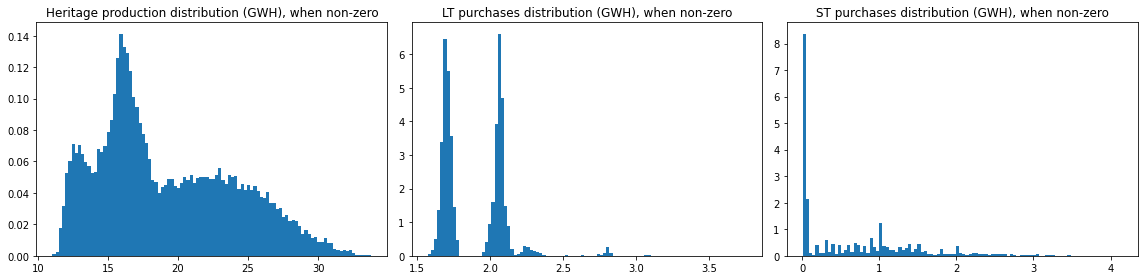

In [10]:
supplies = {
    "Heritage production": "req_production_net",
    "LT purchases": "LT_purchases",
    "ST purchases": "ST_purchases"
}

stats = data[list(supplies.values())].agg([min, max, np.mean, np.median]) / 1e3
stats.columns = list(supplies.keys())
print("Aggregate values, in GWH:\n\n", stats)

fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
for i in range(3):
    key, value = list(supplies.items())[i]
    series = data[value] / 1e3
    axes[i].hist(series.loc[series != 0], bins=100, density=True)
    axes[i].set_title("{} distribution (GWH), when non-zero".format(key))
plt.tight_layout()
plt.show()

How do these distributions change throughout the year, and in relation to each other?

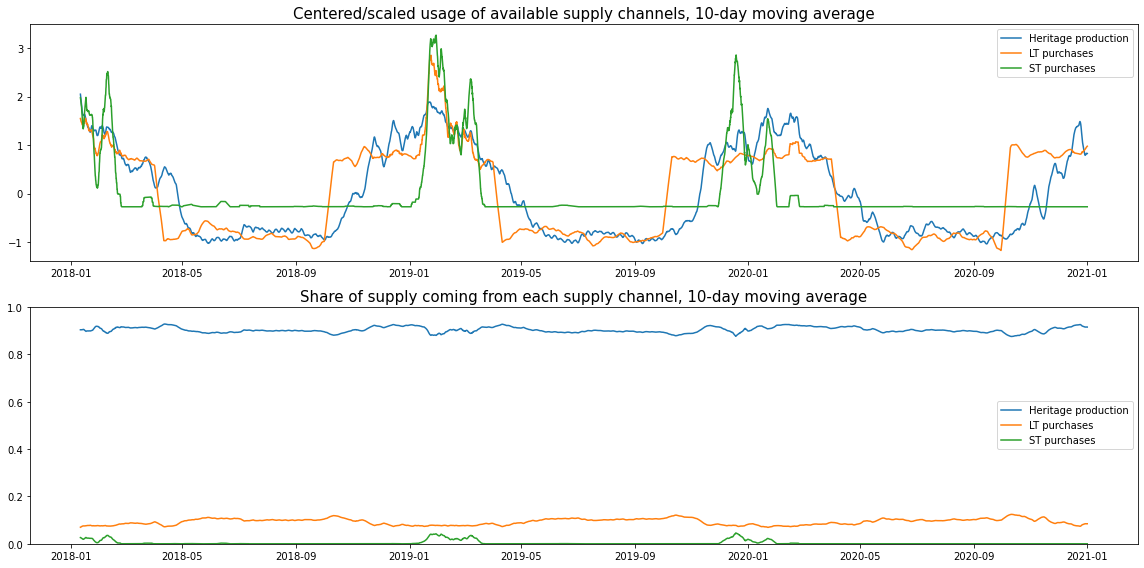

In [11]:
titles = [
    "Centered/scaled usage of available supply channels, {}-day moving average".format(window_days),
    "Share of supply coming from each supply channel, {}-day moving average".format(window_days)
]

fig, axes = plt.subplots(nrows=2, figsize=(16,8))
for key, value in supplies.items():
    x = data[value]
    z = (x - x.mean()) / x.std()
    axes[0].plot(z.rolling(window=window_days*24).mean(), label=key)
    
relativities = data[list(supplies.values())]
relativities = relativities.apply(lambda x: x / x.sum(), axis=1).rolling(window=window_days*24).mean()
axes[1].plot(relativities, label=list(supplies.keys()))
axes[1].set_ylim([0,1])
    
for i in [0, 1]:
    axes[i].set_title(titles[i], fontsize=15)
    axes[i].legend()

plt.tight_layout()
plt.show()

As we can see, HP is slowly ramped up when demand increases during the winter; LT purchases lead the HP changes (in either direction), but much more suddenly; ST purchases are mostly reserved for peak demand periods in the depths of winter.  

Also, HP is clearly preferred to purchases, both LT and ST; LT purchases are in turn preferred to ST purchases.  

#### Changes in usage

Let us now examine how the usage of each supply channel changes from one hour to the next:

C:\Users\archi\.julia\conda\3\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\archi\.julia\conda\3\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


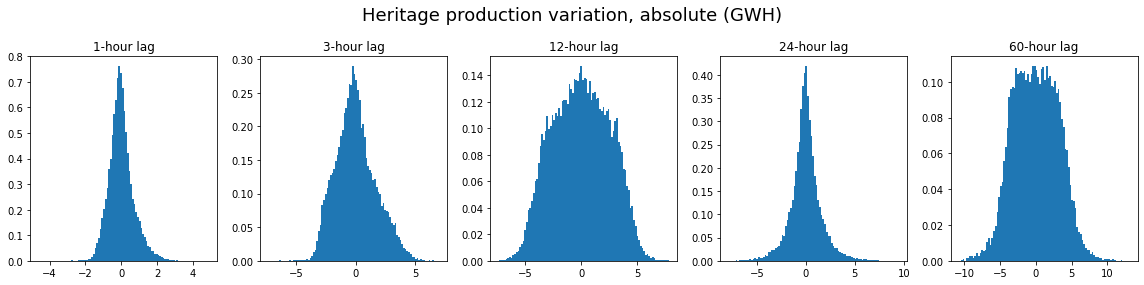

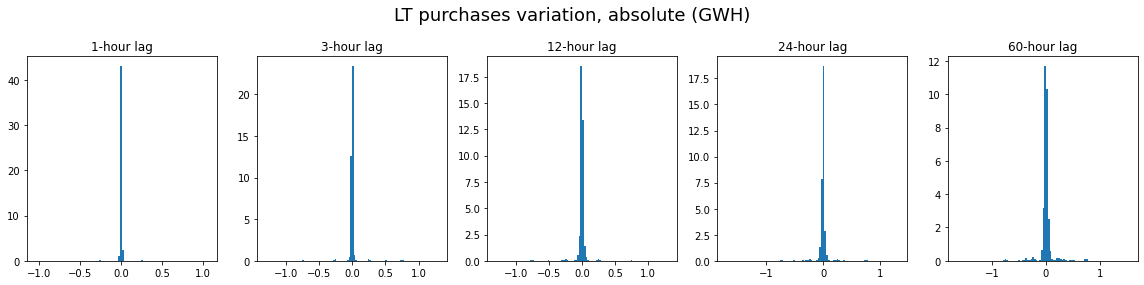

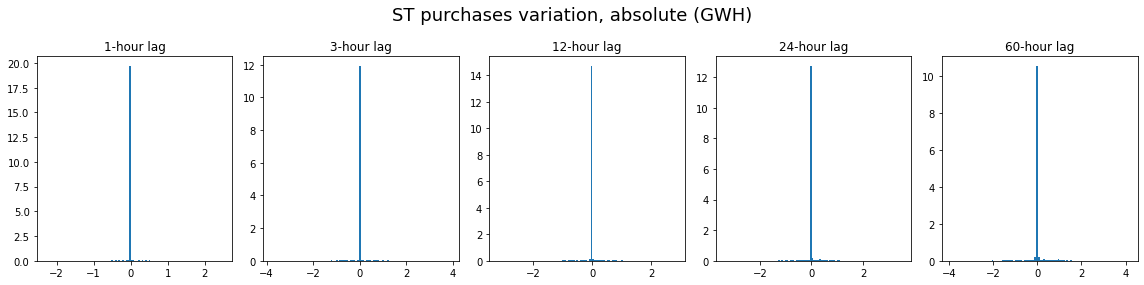

In [12]:
lags = [1, 3, 12, 24, 60]

ncols = len(lags)
for i in range(len(supplies)):
    
    fig, row = plt.subplots(ncols=ncols, figsize=(min(16, 4 * ncols), 4))
    key, value = list(supplies.items())[i]
    
    for j in range(ncols):
        lag = lags[j]        
        series = data[value].diff(periods = lag) / 1e3      
        row[j].hist(series, bins=100, density=True)
        row[j].set_title("{}-hour lag".format(lag))
        
    plt.suptitle("{} variation, absolute (GWH)".format(key), fontsize=18)
    plt.tight_layout()
    plt.show()

LT and ST purchase changes seem to be zero or near zero most of the time. Let's drill down a bit more:


LT purchases
 
Share at zero:				 0.0 
Share in [-0.05, 0.05]:			 0.9854394768856448 
Maximum recorded hourly difference:	 1.062361876245151


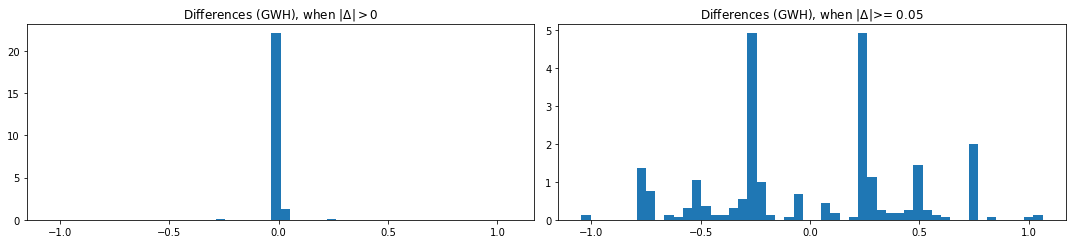


ST purchases
 
Share at zero:				 0.9443430656934306 
Share in [-0.05, 0.05]:			 0.9478026155717761 
Maximum recorded hourly difference:	 2.5


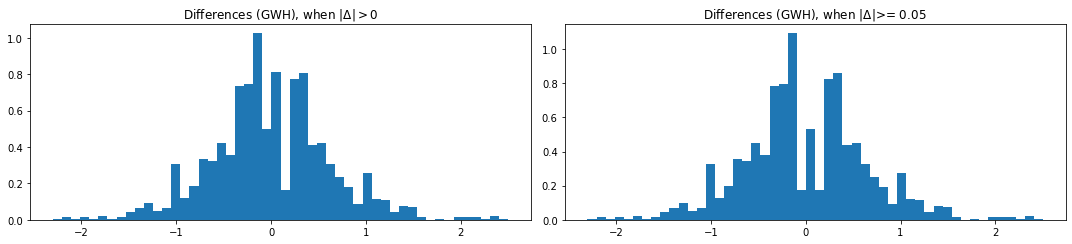

In [13]:
near_zero_threshold = 0.05

for key, value in supplies.items():
    if key == "Heritage production":
        continue # Not our focus here
    series = data[value].diff(periods = 1) / 1e3
    zeros = series == 0
    near_zeros = series.abs() <= near_zero_threshold
    print("\n{}\n".format(key),
          "\nShare at zero:\t\t\t\t", zeros.mean(),
          "\nShare in [-{}, {}]:\t\t\t".format(near_zero_threshold, near_zero_threshold),
          near_zeros.mean(),
          "\nMaximum recorded hourly difference:\t", series.max())
    
    fig, axes = plt.subplots(ncols = 2, figsize=(15, 3.5))
    axes[0].hist(series.loc[~zeros], bins=50, density=True)
    axes[0].set_title("Differences (GWH), when $|\Delta| > 0$")
    
    axes[1].hist(series.loc[~near_zeros], bins=50, density=True)
    axes[1].set_title("Differences (GWH), when $|\Delta|$>= " + str(near_zero_threshold))
    
    plt.tight_layout()
    plt.show()

LT purchases apparently vary at least a little bit, all the time. Let's zoom in:

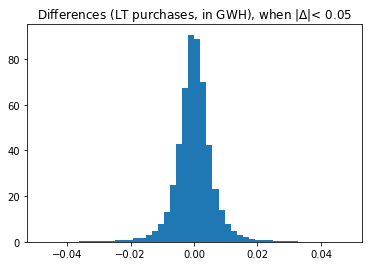

In [14]:
series = data['LT_purchases'].diff(periods = 1) / 1e3
plt.hist(series.loc[series.abs() < near_zero_threshold], bins=50, density=True)
plt.title("Differences (LT purchases, in GWH), when $|\Delta|$< " + str(near_zero_threshold))
plt.show()

Conclusions with respect to supply sources:  
1. HP provides the lion's share of supply, and absorbs most of the variation throughout the year;
2. LT purchases are never zero and always change a least a bit from one hour to the next. They can be scaled up by roughly an additional gigawatt when needed, but the ceiling is reached fairly quickly;
3. ST purchases are clearly used as a stopgap in response to demand spikes. They can be increased by up to 2.5GW within an hour, but cap out at slightly more than 4GW in our dataset. We cannot tell from the data if this represents an upper bound constraint, or whether Hydro-Québec just hasn't had to go there in the three years for which we have data.

### Balance of supply and demand

How frequently do excesses and shortfalls happen, when looking at actual production versus required production?

In [15]:
balance = data['act_production_net'] - data['req_production_net']
print("Share of observations with a shortfall:", (balance < 0).mean())
print("Share of observations with an excess:", (balance > 0).mean())

Share of observations with a shortfall: 0.0
Share of observations with an excess: 0.9990875912408759


From this we can conclude that the problem comes with a "no shortfall, ever" constraint. However, excesses are costly, so we want to minimize them.  

We surmise that there is a lag between decisions for HP, LT purchases and ST purchases, and the moment when these supplies become available. We will assume the following cost/lag relationships: with $c_k$ and $l_k$ the cost and lag, respectively, of option k,  

$$c_\text{HP} < c_\text{LT} < c_\text{ST} \\
l_\text{HP} > l_\text{LT} > l_\text{ST}$$  

### Costs of excess supply

Let's look at the distribution of excesses and of their unit costs:

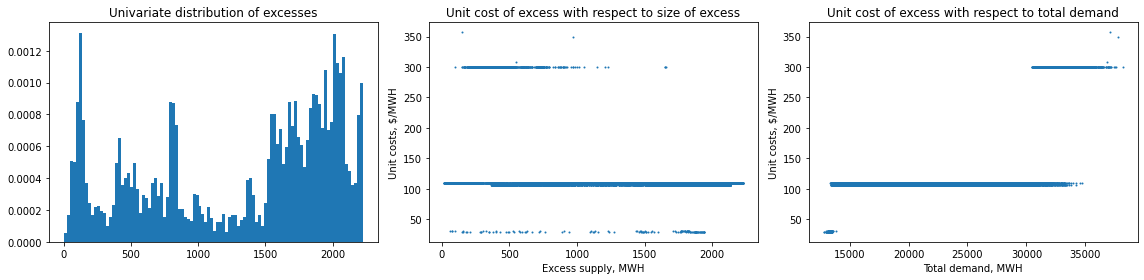

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
axes[0].hist(balance, bins=100, density=True)
axes[0].set_title("Univariate distribution of excesses")
excess = balance > 0

axes[1].scatter(balance.loc[excess], data.loc[excess, 'unit_cost_excess'], s=1)
axes[1].set_title("Unit cost of excess with respect to size of excess")
axes[1].set_xlabel("Excess supply, MWH")
axes[1].set_ylabel("Unit costs, $/MWH")

axes[2].scatter(data.loc[excess, 'req_total'], data.loc[excess, 'unit_cost_excess'], s=1)
axes[2].set_title("Unit cost of excess with respect to total demand")
axes[2].set_xlabel("Total demand, MWH")
axes[2].set_ylabel("Unit costs, $/MWH")

plt.tight_layout()
plt.show()

The size of excesses and their unit costs do not appear to have a direct relationship, but the unit costs of excesses do seem related to the size of total demand. Also, unit costs seem to take on a limited set of discrete values, rather than continuous values. What specific values do these costs take?

In [17]:
relation = data.groupby('unit_cost_excess').req_total.agg([np.mean, len]).sort_index()
relation.columns = ['AvgDemand', 'Frequency']
print(relation)

                     AvgDemand  Frequency
unit_cost_excess                         
29.200000         13340.309524         42
29.600000         13264.571429         42
30.250000         13362.714286         42
105.985000        20878.886315       8418
108.634625        21070.078522       8418
110.000000        20591.394456       8442
300.000000        33246.983278        897
308.790000        36791.000000          1
349.770000        37738.000000          1
357.010000        37049.000000          1


If we lump together observations with similar unit costs, what do the distributions of excesses and total demand look like?

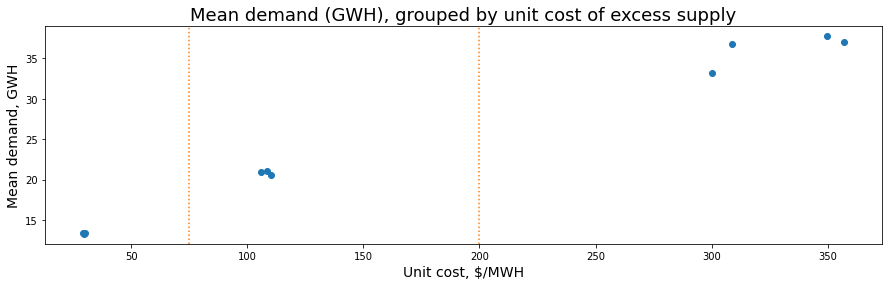

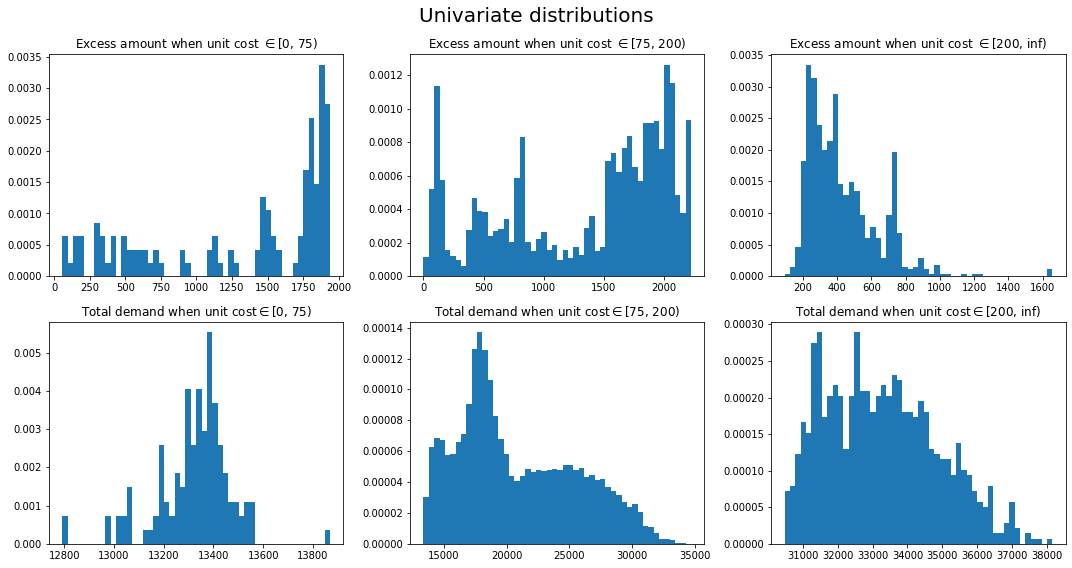

In [18]:
cuts = [0, 75, 200, np.inf]
plt.figure(figsize=(15, 4))
plt.scatter(relation.index, relation.AvgDemand / 1e3)
plt.title("Mean demand (GWH), grouped by unit cost of excess supply", fontsize=18)
plt.xlabel("Unit cost, $/MWH", fontsize=14)
plt.ylabel("Mean demand, GWH", fontsize=14)
for cut in cuts[1:-1]:
    plt.axvline(cut, linestyle='dotted', color='tab:orange')
plt.show()

demand_groups = []
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
for i in range(3):
    subset = (data.unit_cost_excess >= cuts[i]) & (data.unit_cost_excess < cuts[i + 1])
    axes[0, i].hist(balance.loc[subset], bins=50, density=True)
    axes[0, i].set_title("Excess amount when unit cost $\in$[{}, {})".format(cuts[i], cuts[i + 1]))
    demand = data.loc[subset, 'req_total']
    demand_groups.append(demand)
    axes[1, i].hist(demand, bins=50, density=True)
    axes[1, i].set_title("Total demand when unit cost$\in$[{}, {})".format(cuts[i], cuts[i + 1]))
    
plt.suptitle("Univariate distributions", fontsize=20)
plt.tight_layout()
plt.show()

In [19]:
for i in range(3):
    d = demand_groups[i]
    print("Unit cost in [{},{})\t=>\tMin: {}\tMax: {}".format(cuts[i], cuts[i+1], d.min(), d.max()))

Unit cost in [0,75)	=>	Min: 12792	Max: 13869
Unit cost in [75,200)	=>	Min: 13378	Max: 34677
Unit cost in [200,inf)	=>	Min: 30469	Max: 38160


There seems to be very little overlap between the demand levels of the different excess unit cost groups. This will make them easier to simulate!

### Costs of ST purchases

Recall our previously-stated assumption that $c_\text{HP} < c_\text{LT} < c_\text{ST}$. With respect to unit supply costs, we only have data on ST purchases, so we will use arbitrary guesses for the costs of LT purchases and HP. Let us look first at the distribution of ST purchase costs, to get an idea of this baseline we do have data on.  

NB: it seems that ST purchase unit costs are zero when there are not ST purchases for a given observation, so we will filter the data set to focus our analysis on non-zero ST unit cost instances.

In [20]:
ST_cost = 'ST_purchases_unit_cost'
print("Share of observations with non-zero ST unit purchase costs:",
      (data[ST_cost] != 0).mean())

Share of observations with non-zero ST unit purchase costs: 0.16271289537712896


In [21]:
groups = data.groupby(data[ST_cost] == 0).ST_purchases.agg(np.mean)
groups.index = ["Non-zero unit cost", "Zero unit cost"]
print("Mean ST purchases on lines with:")
for i in groups.index:
    print("\t{} => {}".format(i, groups.loc[i]))

Mean ST purchases on lines with:
	Non-zero unit cost => 664.4827479883178
	Zero unit cost => 0.025426807119505995


We seem to have a few anomalies, where ST unit purchase costs are zero but ST purchases are not. How frequent are those observations?

In [22]:
anomalies = data.loc[(data[ST_cost] == 0) & data.ST_purchases != 0].shape[0]
msg = "Lines where ST unit cost is zero but ST purchases are non-zero: {} (out of {})"
print(msg.format(anomalies, data.shape[0]))

Lines where ST unit cost is zero but ST purchases are non-zero: 7 (out of 26304)


Not very much... We can probably just assume that these are mistakes.

Average unit cost of ST purchases ($/kWH):  0.05149526508656068


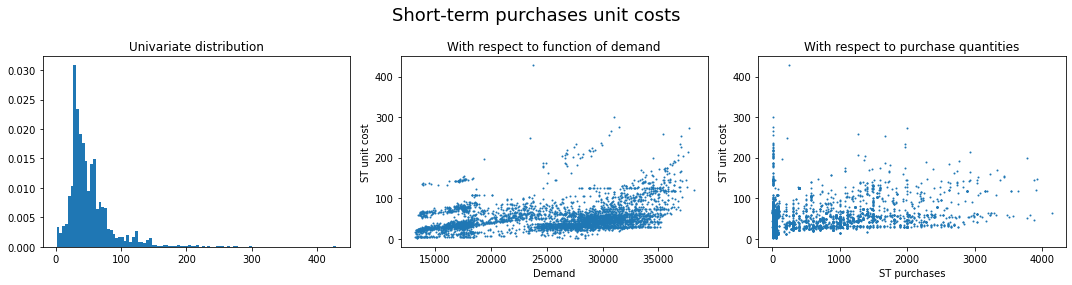

In [23]:
subset = data.loc[data[ST_cost] > 0]
print("Average unit cost of ST purchases ($/kWH): ",
      subset[ST_cost].mean() / 1e3)

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

axes[0].hist(subset[ST_cost], bins=100, density=True)
axes[0].set_title("Univariate distribution")

axes[1].scatter(subset.req_total, subset[ST_cost], s=1)
axes[1].set_title("With respect to function of demand")
axes[1].set_xlabel("Demand")
axes[1].set_ylabel("ST unit cost")

axes[2].scatter(subset.ST_purchases, subset[ST_cost], s=1)
axes[2].set_title("With respect to purchase quantities")
axes[2].set_xlabel("ST purchases")
axes[2].set_ylabel("ST unit cost")

plt.suptitle("Short-term purchases unit costs", fontsize=18)
plt.tight_layout()
plt.show()

As we would expect from an Economics 101 class, ST purchase unit costs are higher when total demand is higher; the relationship appears to be vaguely cubic.

### On the consumption of production facilities

If you were paying attention well enough, earlier, you will have noticed that we have both *gross* and *net* HP requirements, with the consumption of production facilities accounting for the difference. Let us take a quick look at the relationship between facilities' consumption and HP levels:

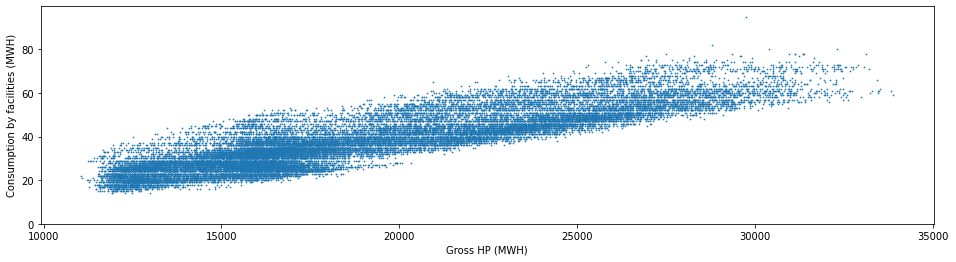

In [24]:
gross = data['req_production_gross']
cons_fac = gross - data['req_production_net']

plt.figure(figsize=(16, 4))
plt.scatter(gross, cons_fac, s=.5)
plt.ylim([0, cons_fac.max() * 1.05])
plt.xlabel("Gross HP (MWH)")
plt.ylabel("Consumption by facilities (MWH)")
plt.show()

It looks like the relationship is pretty linear. We will not bother ourselves trying to model this aspect of the problem. Just to be clear, the total demand in our data also includes the consumption of production facilities, and the HP data is gross.  

*Going forward, we will disregard LT purchases, subtracting their amounts from total demand: their role seems to be relatively marginal, and meaningfully including them would make the problem more complicated than it needs to be for the purpose of this notebook, which is to apply a modelling idea, rather than to guide real-world decisions.*

## Problem statement  

Our objective is to minimize total costs, while having near-certainty of always having sufficient supply (with probability $\alpha$ of falling short for any given period). We define the problem in three stages:  

1. At time T-24h:
    - we know:
        - current demand ($d_1$)
        - unit cost of HP ($c_1$)
    - we decide:
        - how many units of HP to produce ($x_1$) for time T
         
         
2. At time T-1h:
    - we know:
        - $x_1$
        - current demand ($D_2$)
        - unit cost of ST purchases ($C_2$)
    - we decide:
        - how many units of ST supply to buy ($X_2$) for time T
        

3. At time T:
    - we learn:
        - observed demand ($D_3$)
        - unit cost of excess ($C_3$)
        

Mathematically (capital letters denote variables that are unknown at that stage):

- First stage:  
$$\underset{x_1}{\min} c_1x_1 + \mathbb{E}\big[C_2X_2 + C_3(x_1 + X_2 - D_3)^+\ |\ d_1\big] \\
\text{s.t.} \quad x_1 \ge 0$$  

- Second stage:
$$\underset{x_2}{\min} c_2x_2 + \mathbb{E}\big[C_3(x_1 + x_2 - D_3)^+\ | \ d_2,\ x_1\big] \\
\text{s.t.}\quad \mathbb{P}\big(D_3 \le x_1 + x_2 \big) \ge 1-\alpha
\\ \quad x_2 \ge 0$$  

### Acceptable probability of shortfall

We set $\alpha$ to the value that gives us a 95% probability of not seeing a single shortfall in our dataset, assuming hourly shortfalls are independent and identically distributed (iid):  
$$\mathbb{P}\big(N_\text{shortfalls}=0\big) = 0.95
\Longleftrightarrow \big(1-\alpha)^n = 0.95
\Longleftrightarrow \alpha = 1 - 0.95^{1/n}
$$

In [25]:
n = data.shape[0]
α = 1 - 0.95 ** (1 / n)
z_threshold = sps.norm.ppf(1 - α) # Inverse cumulative distribution function of an N(0,1)
print("Acceptable probability of shortfall:\t", round(α, 8),
      "\t(equivalent to ~ 1 / {})".format(round(1 / α)),
      "\nStandard deviations threshold:\t\t", z_threshold)

Acceptable probability of shortfall:	 1.95e-06 	(equivalent to ~ 1 / 512816) 
Standard deviations threshold:		 4.6166397735518085


### Adapting the data

In [26]:
new_names = {
    "req_total": "demand",
    "req_production_gross": "x1",
    "ST_purchases": "x2",
    "ST_purchases_unit_cost": "c2",
    "unit_cost_excess": "c3"
}
data = data.rename(columns=new_names)
data.demand -= (data.LT_purchases + data.excess)
data = data[list(new_names.values())]
data.head()

,demand,x1,x2,c2,c3
time,,,,,
2018-01-01 01:00:00,30302.839304,30270.419652,400.0,124.340000,300.0
2018-01-01 02:00:00,30389.461167,30321.730583,400.0,124.340000,300.0
2018-01-01 03:00:00,30626.030043,30489.015022,400.0,124.340000,300.0
2018-01-01 04:00:00,30756.160883,30494.080441,575.0,104.820891,300.0
2018-01-01 05:00:00,30842.637521,30832.318761,575.0,96.309634,300.0


## Models to simulate random inputs

The problem has four exogenous random variables (we will assume them to be *iid*):  
- demand at stages 2 and 3, once the previous stage's demand is known: $D_2|d_1$, $D_3|D_2$
- unit cost of ST purchases at stage 2, once $D_2$ is known: $C_2|D_2$
- unit cost of excess supply at stage 3, once $D_3$ is known: $C_3|D_3$  

### Conditional demand model

We will assume that $D_t|D_{t-T}$ variables follow a Normal($\mu$, $\sigma$) distribution, where the parameters ($\mu$, $\sigma$) are estimated using linear regression.

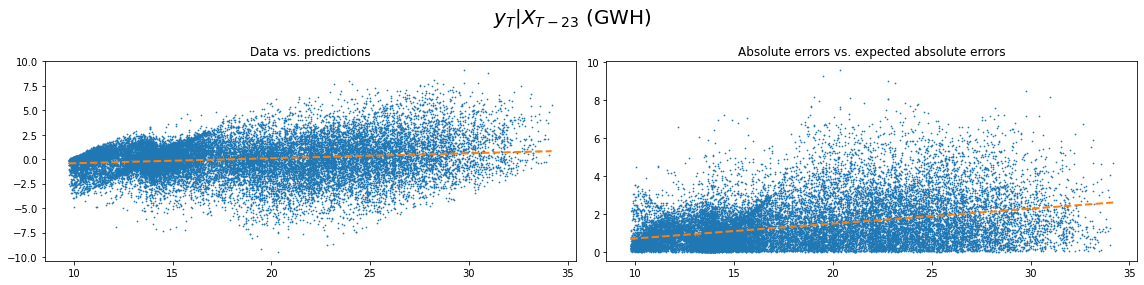

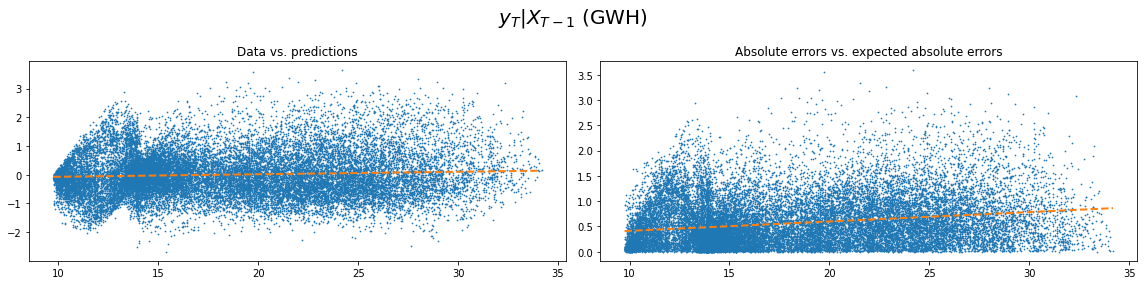

In [27]:
class ConditionalDemandModel():
    
    def __init__(self, 
                 T: int,
                 X: pd.DataFrame,
                 y: pd.Series,
                 plot: bool = False,
                 scale: float = 1e3,
                 suffix: str = " (GWH)",
                 *args, **kwargs):
        
        self.scale = scale
        
        # Series of differences
        lagged = y.diff(periods = T)
        lagged.index = (lagged.index - pd.Timedelta(T, units="hours")).round(freq="s")
        lagged.name = "y"        
        
        # Combine the dependent and independent variables
        _data = X.to_frame().iloc[:-T].join(lagged).dropna() / scale
        X, y = _data.drop('y', axis=1).to_numpy(), _data.y.to_numpy()
        
        # Initialize and fit models
        self.μ_model = LinearRegression()
        self.μ_model.fit(X, y)
        residuals = np.absolute(y - self.μ_model.predict(X))        
        
        self.σ_model = LinearRegression()
        self.σ_model.fit(X, residuals)
        
        if plot:
            for i in range(X.shape[1]):
                _X = X[:, i]
                X_plot = np.linspace(_X.min(), _X.max(), 100)[:, np.newaxis]
                E_plot = self.μ_model.predict(X_plot)
                σ_plot = self.σ_model.predict(X_plot)
                
                fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
                axes[0].scatter(_X, y, s=0.5)
                axes[0].plot(X_plot.flatten(), E_plot, 
                             linestyle="dashed", color="tab:orange", linewidth=2)
                axes[0].set_title("Data vs. predictions")
                
                axes[1].scatter(_X, residuals, s=0.5)
                axes[1].plot(X_plot.flatten(), σ_plot, 
                             linestyle="dashed", color="tab:orange", linewidth=2)
                axes[1].set_title("Absolute errors vs. expected absolute errors")
                
                if X.shape[1] == 1:
                    suptitle = "$y_T|X_{T-" + str(T) + "}$"
                else:
                    suptitle = "$y_T|X_{T-" + str(T) + "," + str(i + 1) + "}$"
                plt.suptitle(suptitle + suffix, fontsize=20)
                plt.tight_layout()
                plt.show()                
                
    def distr_params(self,
                     X: np.ndarray,
                     rescale: bool = True):
        """
        Allows us to extract only the conditional parameters given the known
        value, rather than necessarily simulate.
        """
        μ = self.μ_model.predict(X / self.scale)
        σ = self.σ_model.predict(X / self.scale)
        if rescale:
            μ *= self.scale
            σ *= self.scale
        if X.shape[0] > 1:
            μ, σ = μ[:, np.newaxis], σ[:, np.newaxis]
        return μ, σ
    
    def simulate(self,
                 X: np.ndarray,
                 n: int = 1):        
        if type(X) != np.ndarray:
            X = np.array([X]).flatten()[:, np.newaxis] # Standardize shape
        μ, σ = self.distr_params(X)
        sims = sps.norm.rvs(loc=μ, scale=σ, size=(X.shape[0], n)) # N(μ,σ) random variates
        return X + sims
    
    def inverse(self,
                X: np.ndarray,
                U: np.ndarray):
        """
        Outputs specified quantiles of conditional demand variation distributions,
        once the conditionand is known.
        """
        if type(X) != np.ndarray:
            X = np.array([X]).flatten()[:, np.newaxis]
        μ, σ = self.distr_params(X)
        z = sps.norm.ppf(U)
        F_inv = μ + z * σ
        return F_inv
    
    
d2_model = ConditionalDemandModel(
    T = 23,
    X = data.demand.copy(),
    y = data.demand.copy(),
    plot = True
)
d3_model = ConditionalDemandModel(
    T = 1,
    X = data.demand.copy(),
    y = data.demand.copy(),
    plot = True
)

Let's take these models for a spin...

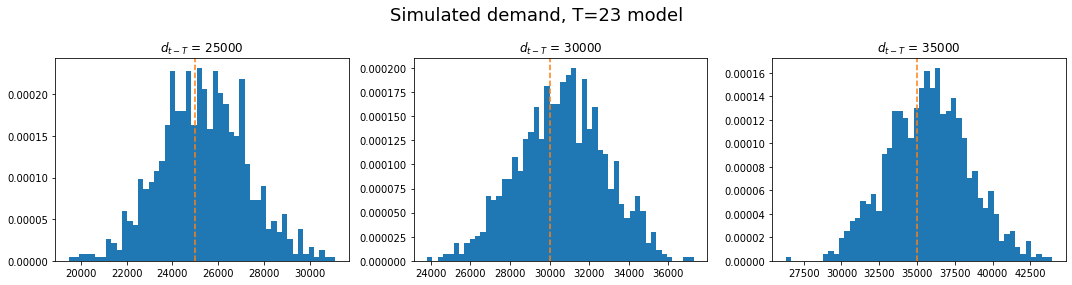

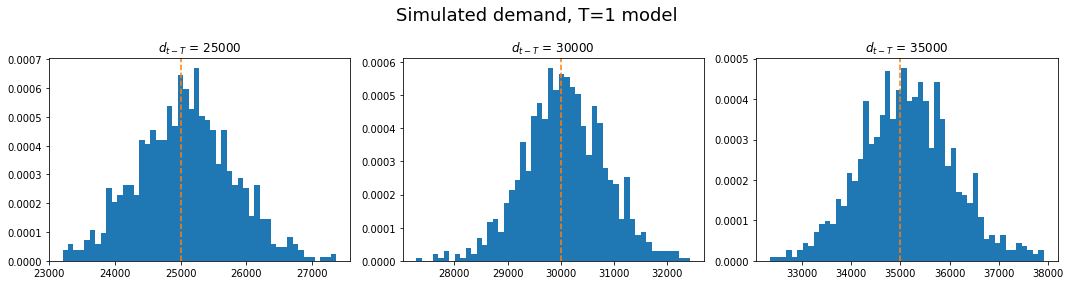

In [28]:
demand_t0 = [25000, 30000, 35000]
demand_models = {"T=23": d2_model, "T=1": d3_model}

for key, value in demand_models.items():
    sims = value.simulate(n=1000, X=demand_t0)
    fig, axes = plt.subplots(ncols=3, figsize=(15,4))
    for i in range(3):
        axes[i].hist(sims[i], bins=50, density=True)
        axes[i].axvline(demand_t0[i], color="tab:orange", linestyle="dashed")
        axes[i].set_title("$d_{t-T}$ = " + str(demand_t0[i]))
    plt.suptitle("Simulated demand, {} model".format(key), fontsize=18)
    plt.tight_layout()
    plt.show()

### Conditional unit cost models

While conditional demands can reasonably be modelled as following Normal random variables, unit costs appear much less regular (probably reflecting some variables that are excluded from the data). To avoid making assumptions about their distributions, we will use a relatively simple bootstrap model, where the unit cost $C_{sim}$ for a given $D_t$ is drawn at random from the data, with the probability:  

$$\mathbb{P}(C_{sim} = c_i) = \frac{(D_t - d_i)^{-2}}{\sum_{i=1}^n(D_t - d_i)^{-2}}$$  

where $c_i$ and $d_i$ are the unit cost and demand, respectively, for observation $i$

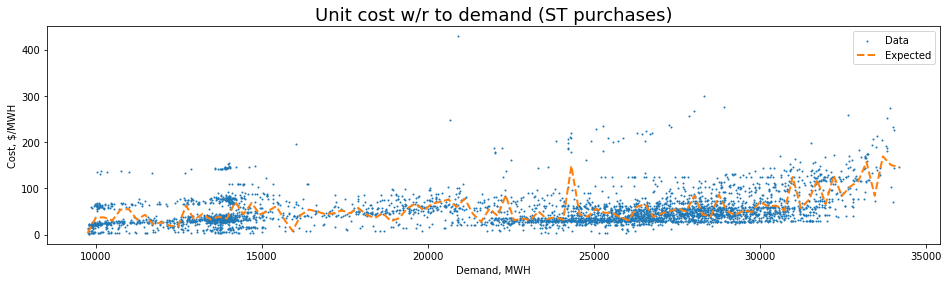

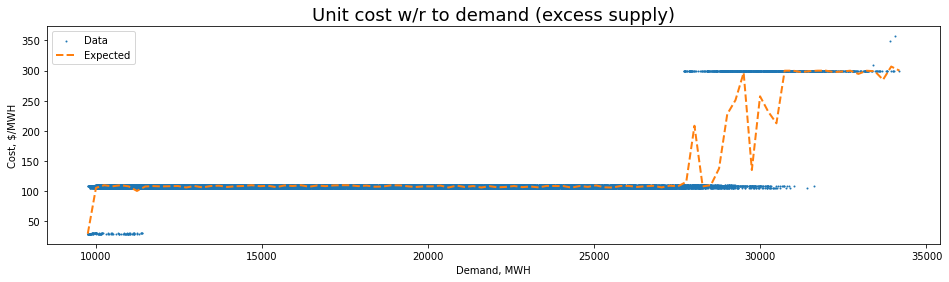

In [29]:
class ConditionalCostModel():
    
    def __init__(self,
                 X: pd.Series,
                 y: pd.Series,
                 plot: bool = False,
                 cost_name: str = "",
                 *args, **kwargs):
        if type(X) != np.ndarray:
            X = np.array(X)
        X = X[y != 0]
        y = y.loc[y != 0]
        order = np.argsort(y)
        self.X = X[order]
        self.y = y.iloc[order]
        
        if plot:
            X_plot = np.linspace(self.X.min(), self.X.max(), 100)
            y_hats = np.array([self.expect(x) for x in X_plot])
            plt.figure(figsize=(16, 4))
            plt.scatter(self.X, self.y, s=1, label="Data")
            plt.plot(X_plot, y_hats, label="Expected", 
                     linestyle="dashed", color="tab:orange", linewidth=2)
            plt.legend()
            plt.xlabel("Demand, MWH")
            plt.ylabel("Cost, $/MWH")
            plt.title(" ".join(["Unit cost w/r to demand", "({})".format(cost_name)]), fontsize=18)
            plt.show()            
        
    def p_matrix(self,
                 X: np.ndarray,
                 eps: float = 1e-6):
        """
        Generates a vector or matrix of selection probabilities based on
        relative squared distances between a given X and sample values.
        
        In the returned matrix, each row corresponds to the probability associated
        to each sample value; if X is a vector, the j-th column of the returned matrix
        corresponds to the probabilities vector for the j-th element of X.
        """
        X = np.array([X]).flatten()[np.newaxis] # Standardize shape
        dist = 1 / np.maximum(eps, (X - self.X[:, np.newaxis]) ** 2)
        return dist / dist.sum(0)
        
    def simulate(self,
                 X: float,
                 n: int = 1):
        p = self.p_matrix(X).flatten()
        return self.y.sample(weights=p, n=n, replace=True)
    
    def expect(self,
               X: np.ndarray):
        p = self.p_matrix(X)
        return np.sum(self.y.to_numpy()[:, np.newaxis] * p, axis=0)
    
    def inverse(self,
                X: np.ndarray,
                U: np.ndarray):
        p = self.p_matrix(X)
        cdf = np.cumsum(p, axis=0)
        F_inv = np.array([
            self.y.iloc[np.where(cdf[:, i] >= U[i])[0].min()]
            for i in range(len(U))
        ])
        return F_inv
    
c2_model = ConditionalCostModel(
    X = data.demand,
    y = data.c2,
    plot = True,
    cost_name = "ST purchases"
)

c3_model = ConditionalCostModel(
    X = data.demand,
    y = data.c3,
    plot = True,
    cost_name = "excess supply"
)

Let's try them out...

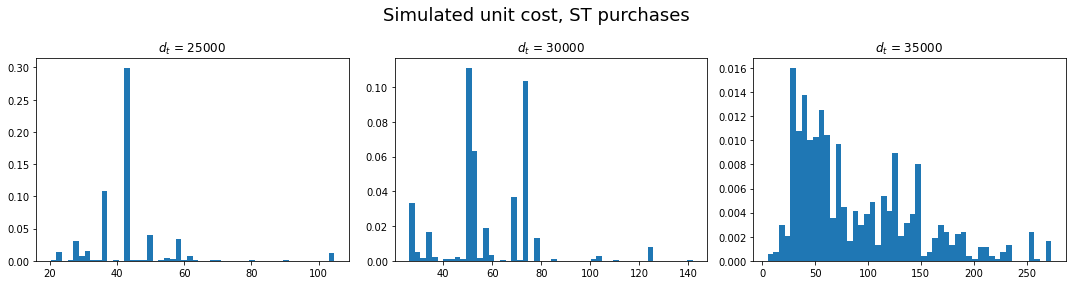

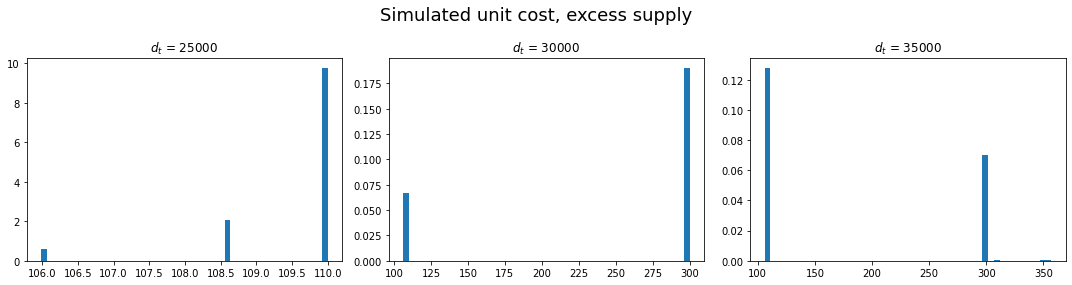

In [30]:
cost_models = {"ST purchases": c2_model, "excess supply": c3_model}
for key, value in cost_models.items():
    sims = [value.simulate(n=1000, X=x) for x in demand_t0]
    fig, axes = plt.subplots(ncols=3, figsize=(15,4))
    for i in range(3):
        axes[i].hist(sims[i], bins=50, density=True)
        axes[i].set_title("$d_t$ = " + str(demand_t0[i]))
    plt.suptitle("Simulated unit cost, {}".format(key), fontsize=18)
    plt.tight_layout()
    plt.show()

## Optimization

We set the cost of first-stage production at 30$/MWH.

In [31]:
C1 = 30.

### Model simplification

A closer look at the second-stage decision reveals that minimizing the objective at this stage is trivial:  
- the objective $\theta$ is comonotonous with respect to $x_2$, i.e. $x_{2,i}>x_{2,j} \Longleftrightarrow \theta_i>\theta_j$ for any $(i,j)$;
- the "sufficient supply" chance constraint is met only if $x_2 \ge d_2 + \mu_{\Delta_{23}} + z_{\text{constraint}} \sigma_{\Delta_{23}} - x_1$, with:
    - $\mu_{\Delta_{23}}$ the expected difference between $D_3$ and $d_2$
    - $\sigma_{\Delta_{23}}$ the standard deviation of the difference between $D_3$ and $d_2$
    - $z_{\text{constraint}} \approx 4.62$ the standard deviation threshold associated to the previously-stated $\alpha$ probability of insufficient supply
    
Therefore:  
$$x_2^*|d_2 = d_2 + \mu_{\Delta_{23}} + z_{\text{constraint}} \sigma_{\Delta_{23}} - x_1$$  

which, in effect, simplifies the problem to a two-stage problem.

In [32]:
def second_stage_decisions(x1: np.ndarray,
                           d2: np.ndarray,
                           d3_demand: ConditionalDemandModel = d3_model,
                           z_constraint: float = z_threshold):
    μ, σ = d3_demand.distr_params(X = d2)
    x1 = np.array([x1]).flatten()[np.newaxis] # Standardize shape
    x2 = d2 + μ + z_constraint * σ - x1
    return np.maximum(0, x2)

### Benchmark: Monte Carlo with naive sample average approximation

In Monte Carlo approaches, the basic idea is to approximate a function's expectation through sampling. Let:  
- $\Theta$ be the function to approximate,
- $\omega\in\Omega$ the possible outcomes defining $\Theta$
- $c(\omega)$ the cost associated with outcome $\omega$
- $p(\omega)$ the probability mass associated to $\omega$  

Then, we estimate:  
$$\mathbb{E}\big[\Theta\big]
= \underset{\omega}{\sum}c(\omega)p(\omega)
= \frac{1}{n}\sum_{i=1}^nc(\omega_i)$$

This is called *naive* sampling, i.e. it is based on the unmodified probability distribution of the phenomenon we need to model. To illustrate the contrast with importance sampling, we will first minimize the objective using stochastic gradient descent and the naive approach, building into these functions the hooks we will use later on to modify the sampling procedure (the random variates will follow $\text{Uniform}(0,1)$ distributions, which we will translate into quantiles using the cost/demand models' dedicated methods).

In [33]:
def second_stage(d1: float,
                 x1: np.ndarray,
                 demand_models: dict,
                 cost_models: dict,
                 U: np.ndarray = None,
                 mod_U: np.ndarray = None,
                 n: int = 1,
                 z_constraint: float = z_threshold,
                 cdf_modifier: callable = lambda x: x,
                 sample_modifier: callable = lambda x, u: x,
                 **kwargs):

    # Standardize the format
    x1 = np.array([x1]).flatten()
    
    # Random variates
    if U is None:
        U = np.random.uniform(size=(n, 4))    
    if mod_U is None:
        mod_U = cdf_modifier(U)
        
    q = sample_modifier
    
    # Demand
    d2 = d1 + q(demand_models['d2'].inverse(X=d1, U=mod_U[:,[0]]), mod_U[:,[0]])
    d3 = d2 + q(demand_models['d3'].inverse(X=d2, U=mod_U[:,[1]]), mod_U[:,[1]])
    
    # ST purchase costs
    c2 = q(cost_models['c2'].inverse(X=d2, U=mod_U[:,[2]]), mod_U[:,2]) # ST purchase
    x2 = second_stage_decisions(
        x1 = x1,
        d2 = d2,
        d3_demand = demand_models['d3'],
        z_constraint = z_constraint
    )    
    
    # Excess supply costs
    c3 = q(cost_models['c2'].inverse(X=d3, U=mod_U[:,[3]]), mod_U[:,3]) # Excesses
    excesses = np.maximum(0, x1 + x2 - d3)
    
    return c2.dot(x2) + c3.dot(excesses) / n


def optimize_first_stage(d1: float,
                         demand_models: dict,
                         cost_models: dict,
                         c1: float = C1,
                         n: int = 1,
                         start_x1_diff: float = 0.,
                         max_iter: int = 10,
                         tol: float = 1e-3,
                         eps: float = 1e-6,
                         learn_rate: float = 1.,
                         z_constraint: float = z_threshold,
                         cdf_modifier: callable = lambda x: x,
                         sample_modifier: callable = lambda x, u: x,
                         return_details: bool = False,
                         verbose: bool = False,
                         **kwargs):
    
    fixed_args = {
        "d1": d1,
        "n": n,
        "demand_models": demand_models,
        "cost_models": cost_models,
        "z_constraint": z_constraint,
        "sample_modifier": sample_modifier
    }
    
    # Starting values
    obj = 1e9
    cur_iter = 0
    x1 = d1 + start_x1_diff
    
    # Learning history
    x1_vec = []
    obj_vec = [obj]
    
    # If the tqdm package cannot be installed/loaded for some reason,
    # uncomment the following line and comment out the one after that
    #for cur_iter in range(max_iter):
    for cur_iter in tqdm(range(max_iter)):
        
        # Fix random variates at each iteration, to stabilize gradient estimations
        fixed_args["U"] = U = np.random.uniform(size=(n, 4))
        fixed_args["mod_U"] = mod_U = cdf_modifier(U)
                
        # Objective and estimated gradient
        obj_func = lambda x: second_stage(x1=x, **fixed_args)[0] + x * c1
        obj = obj_func(x1)
        grad = (obj_func(x1 + eps) - obj_func(x1 - eps)) / (2 * eps)
        if verbose:
            print("n, x1, obj, grad:", np.round([n, x1, obj, grad], 4))
        
        # Record history
        x1_vec.append(x1)
        obj_vec.append(obj)
        
        # Update
        x1 -= learn_rate * grad
        
        # Stopping criteria
        improvement = abs(obj_vec[cur_iter] - obj_vec[cur_iter - 1])
        if improvement <= tol or abs(grad) <= tol:
            break
        
    if return_details:
        return np.array(x1_vec), np.array(obj_vec)
    else:
        return x1, obj

### Importance sampling

For *importance* sampling, we introduce a synthetic probability mass function $q(\omega)$:  
$$\mathbb{E}\big[\Theta\big]
= \underset{\omega}{\sum}c(\omega)p(\omega)
= \underset{\omega}{\sum}\frac{c(\omega)p(\omega)}{q(\omega)}q(\omega)$$

In the problem we are studying, extreme cases have the most impact:  
- strongly negative demand differentials can induce large excesses
- strongly positive demand differentials force larger amounts of ST purchases
- unusually low or high unit costs add to the variance of results  

With this in mind, we would like our $q(\omega)$ density to be minimized in the middle of the distribution, and maximized as we approach $0^+$ or $1^-$. Therefore, we pick a density such that $q(\omega) \propto (\omega-0.5)^2$. Specifically, we will use (the constant ensures that $\int_0^1q(\omega)d\omega = 1)$:  
$$q(\omega) = 12\big(\omega^2 - \omega + \frac{1}{4}\big)\mathbb{I}\{\omega\in[0,1]\}$$  

To sample from this distribution, we will find the values of $\omega$ such that the drawn values of $U\sim\text{Uniform}(0,1)$ correspond to the cumulative distribution $Q(\omega)$:  
$$ U
= Q(\omega) 
= \int_0^\omega q(x)dx
= 12\big(\frac{\omega^3}{3} - \frac{\omega^2}{2} + \frac{\omega}{4} \big)$$  

Once we've identified the value of $\omega$ such that $12\big(\frac{\omega^3}{3} - \frac{\omega^2}{2} + \frac{\omega}{4} \big) - U = 0$ (we will use `Scipy`'s scalar root-finding function to accomplish this), we compute $z=\Phi^{-1}(\omega)$, where $\Phi^{-1}(\gamma)$ is the $\gamma^{\text{th}}$ quantile of a $\text{Normal}(0,1)$ random distribution, and use this to derive whichever demand or cost function we are simulating (to which we will refer here as $f(z)$). With $p(\omega)$ taken as $\frac{1}{n}$ like we did for naive sampling, our estimate becomes:  
$$\mathbb{E}\big[\Theta\big]
= \frac{1}{n} \sum_{i=1}^n \frac{f(z_i)}{q(\omega_i)}$$  

Let us now encode this density/cumulative distribution pair, and visualize how it changes the sampling distribution.

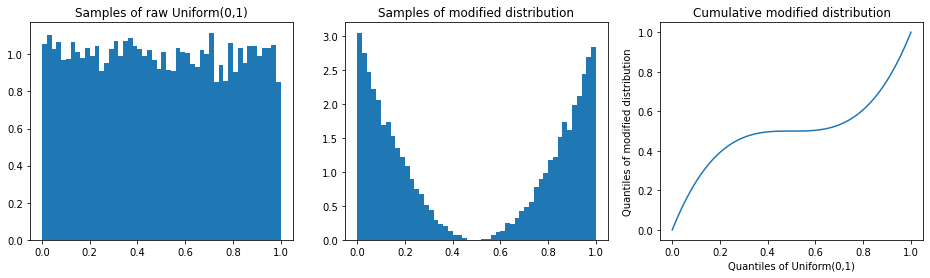

In [34]:
def q_w(x: np.ndarray,
        u: np.ndarray):
    return x / (12 * (u**2 - u + 0.25))

def Q_w(U: np.ndarray):
    if np.ndim(U) > 1: # Multidimensional case
        Q = np.array([Q_w(u) for u in U])
    else:
        F = lambda x, u: 12 * (x**3 / 3 - x**2 / 2 + x / 4) - u
        Q = np.array([
            root_scalar(F, args=(u), bracket=(0.,1.)).root
            for u in U
        ])
    return Q

example_U = np.random.uniform(size=(500,30))
mod_example_U = Q_w(example_U)

fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
axes[0].hist(example_U.flatten(), bins=50, density=True)
axes[0].set_title("Samples of raw Uniform(0,1)")
axes[1].hist(mod_example_U.flatten(), bins=50, density=True)
axes[1].set_title("Samples of modified distribution")
u = np.linspace(0,1,100)
F = lambda x: 12 * (x**3 / 3 - x**2 / 2 + x / 4)
axes[2].plot(u, F(u))
axes[2].set_xlabel("Quantiles of Uniform(0,1)")
axes[2].set_ylabel("Quantiles of modified distribution")
axes[2].set_title("Cumulative modified distribution")
plt.show()

Let's take a quick look at how this actually modifies the distribution of second-stage cost, using arbitrary $d_1$ and $x_1$ values:

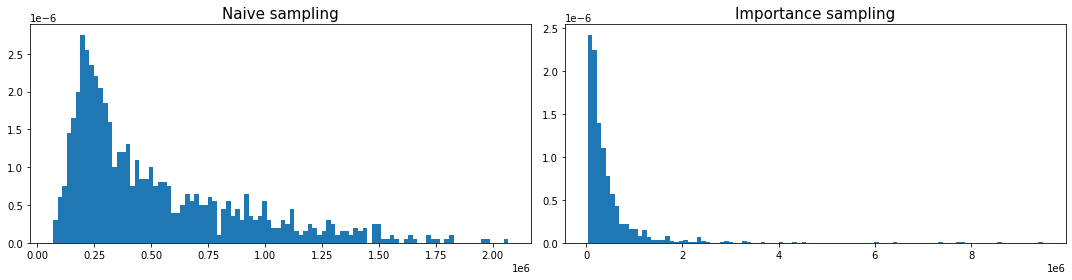

In [35]:
kwargs ={
    "d1": 30000,
    "x1": 33000,
    "demand_models": {"d2": d2_model, "d3": d3_model},
    "cost_models": {"c2": c2_model, "c3": c3_model}
}

n = 1000
types = ["Naive", "Importance"]
samples = [
    np.concatenate([
        second_stage(**kwargs)
        for _ in range(n)
    ]),
    np.concatenate([
        second_stage(
            cdf_modifier = Q_w,
            sample_modifier = q_w,
            **kwargs
        )
        for _ in range(n)
    ])
]

fig, axes = plt.subplots(ncols=2, figsize=(15,4))
for i in [0, 1]:
    axes[i].hist(samples[i], bins=100, density=True)
    axes[i].set_title("{} sampling".format(types[i]), fontsize=15)
plt.tight_layout()
plt.show()

As we can see, importance sampling produces a distribution that is more or less of the same scale as naive sampling, albeit with more extreme outliers than we get with naive sampling.

### Comparing the two

We will now test the idea that importance sampling should help us find optimal solutions more quickly than naive sampling. We will perform this test using, in turn, $d_1=(25, 30, 35)$ (in GWH), with $x_1=d_1$ initially. We will look for optimal values of $x_1$ over up to $100$ iterations, each of which will estimate the objective function by averaging $100$ random scenarios, to be drawn using each method.  

After, we will:  
1. Visually compare the evolution of estimated optimal values and objective functions for each method;
2. Compare the performance of each method's solution, at different points in training, based on the average cost obtained using each solution, when simulating test scenarios with *naive* sampling.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


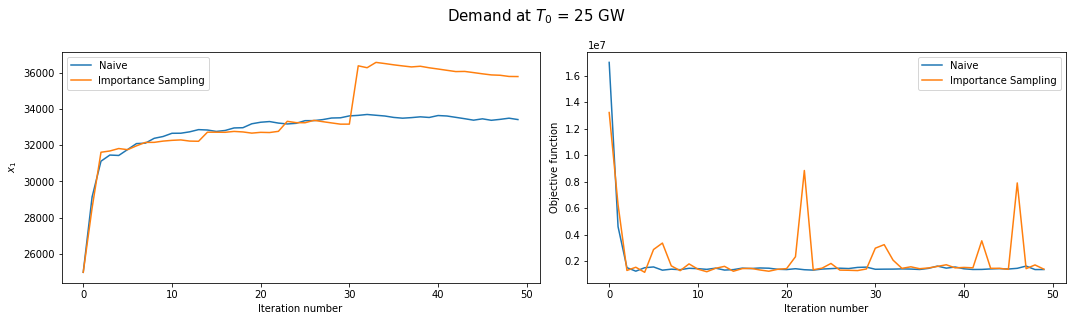

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


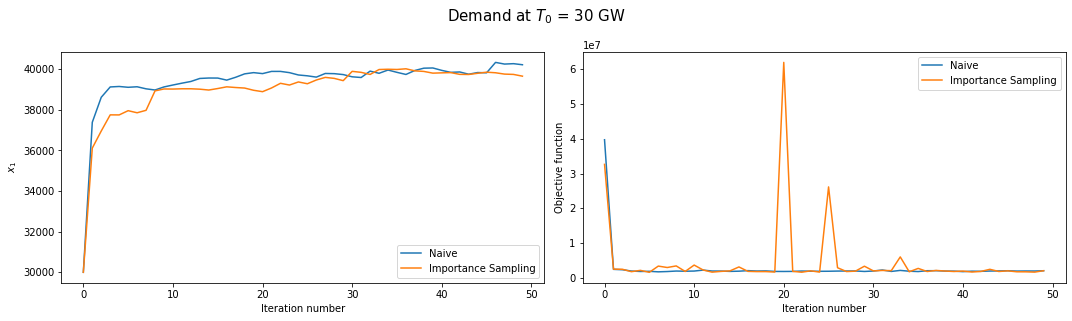

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


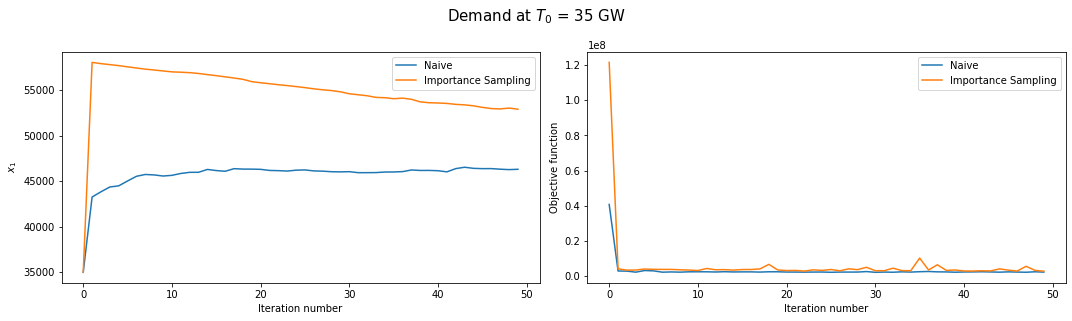



*****   TESTING THE SOLUTIONS   *****


Demand at t0: 25GWH

After 5 training episodes: 
Naive:     	x1: 31433.07389691472	Mean objective: 1713870.0902549597 
Importance:	x1: 31814.635125920177	Mean objective: 1582505.8140010023

After 10 training episodes: 
Naive:     	x1: 32476.547616533935	Mean objective: 1456510.4277613477 
Importance:	x1: 32223.635097034276	Mean objective: 1492410.2449362236

After 20 training episodes: 
Naive:     	x1: 33177.462965250015	Mean objective: 1417622.8660822946 
Importance:	x1: 32662.969990633428	Mean objective: 1438355.189430917

After 50 training episodes: 
Naive:     	x1: 33409.44971423596	Mean objective: 1417841.162869877 
Importance:	x1: 35777.3708878085	Mean objective: 1550851.5224896874


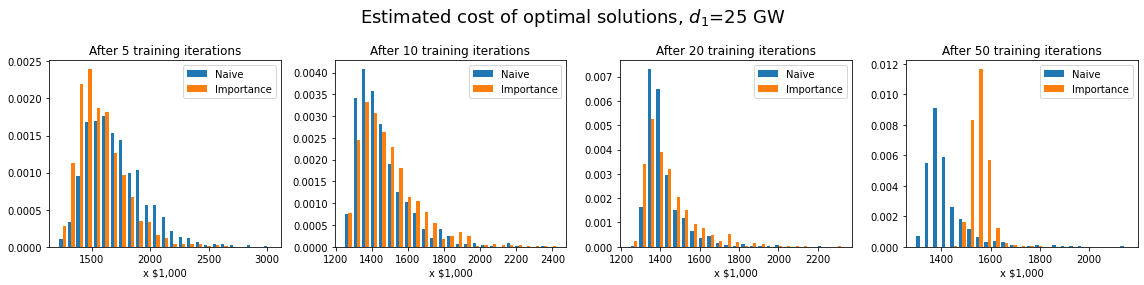


Demand at t0: 30GWH

After 5 training episodes: 
Naive:     	x1: 39151.91986132413	Mean objective: 1973895.0384360135 
Importance:	x1: 37751.0632108897	Mean objective: 2551964.878848193

After 10 training episodes: 
Naive:     	x1: 39129.123645834625	Mean objective: 1976287.9175726757 
Importance:	x1: 39029.34791520238	Mean objective: 1988260.3017796942

After 20 training episodes: 
Naive:     	x1: 39833.60270038247	Mean objective: 1945775.5966519888 
Importance:	x1: 38964.39957432449	Mean objective: 1997333.0605696854

After 50 training episodes: 
Naive:     	x1: 40222.140699625015	Mean objective: 1955709.9148816208 
Importance:	x1: 39659.45853386074	Mean objective: 1946468.7233191603


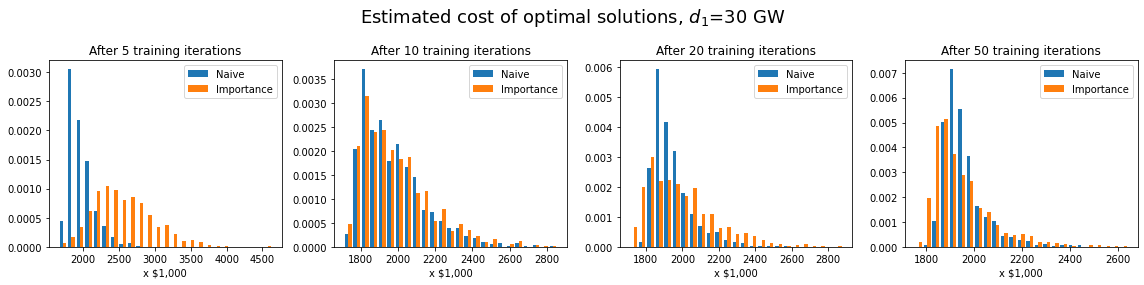


Demand at t0: 35GWH

After 5 training episodes: 
Naive:     	x1: 44487.607050687075	Mean objective: 2639643.0357523835 
Importance:	x1: 57680.072113871574	Mean objective: 3653908.626829008

After 10 training episodes: 
Naive:     	x1: 45564.80244733393	Mean objective: 2453675.980520892 
Importance:	x1: 57094.47696805	Mean objective: 3585589.1164327418

After 20 training episodes: 
Naive:     	x1: 46321.14860229194	Mean objective: 2435921.805253907 
Importance:	x1: 55919.53810304403	Mean objective: 3448512.7615901227

After 50 training episodes: 
Naive:     	x1: 46303.548235446215	Mean objective: 2435642.290132145 
Importance:	x1: 52895.817989483476	Mean objective: 3095745.0188794537


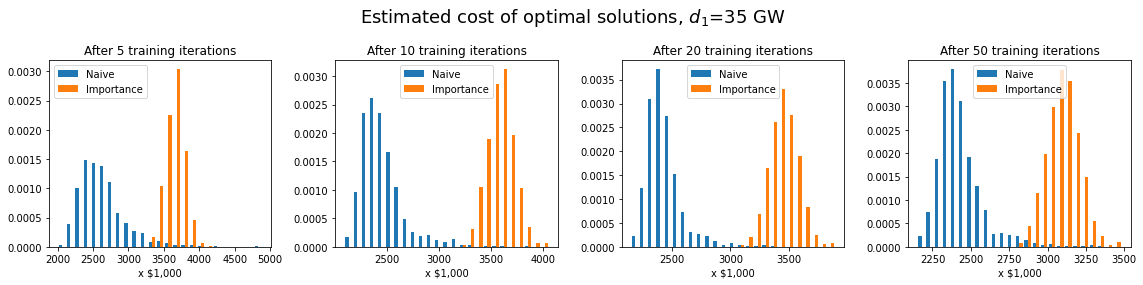

In [36]:
def train_and_test(d1_cases: list,
                   iterations: np.ndarray,
                   test_sims: int,
                   hist_bins: int = 10,
                   x1_start_diffs: list = None,
                   **optimize_args):
    
    results = {}
    comparisons = {}
    steps = len(iterations)
    labels = ["Naive", "Importance Sampling"]
    optimize_args["max_iter"] = iterations.max()
    
    # Optimize using each sampling technique
    for d1 in d1_cases:
        optimize_args['d1'] = d1
        if x1_start_diffs is not None:
            # To reduce the jump in optimal value for early iterations
            # (the values fed here come from observing the results of previous runs)
            i = np.where(np.array(d1_cases) == d1)[0][0]
            optimize_args['start_x1_diff'] = x1_start_diffs[i]
        case_results = [
            optimize_first_stage(**optimize_args),
            optimize_first_stage(
                cdf_modifier = Q_w,
                sample_modifier= q_w,
                **optimize_args
            )
        ]    
        results[d1] = case_results
        
        # Plot solutions and minima
        fig, axes = plt.subplots(ncols=2, figsize=(15, 4.5))
        for i in [0, 1]:
            axes[0].plot(case_results[i][0], label=labels[i])     # x_1
            axes[1].plot(case_results[i][1][1:], label=labels[i]) # Objective value
            axes[i].set_xlabel("Iteration number")
        axes[0].set_ylabel("$x_1$")
        axes[1].set_ylabel("Objective function")
        for i in [0, 1]:
            axes[i].legend()
        plt.suptitle("Demand at $T_0$ = {} GW".format(int(d1 / 1e3)), fontsize=15)
        plt.tight_layout()
        plt.show()

    # Compare the solutions on the basis of naive sampling
    print("\n\n*****   TESTING THE SOLUTIONS   *****\n")
    for d1 in d1_cases:        
        optimize_args['d1'] = d1
        argmins = lambda i: results[d1][i][0][iterations - 1]
        x1 = np.concatenate([argmins(0), argmins(1)])
        comparison = {
            "Naive": {"argmins": x1[:steps]},
            "Importance": {"argmins": x1[steps:]}
        }        
        # We test multiple solutions at once
        performance = np.array([
            second_stage(x1 = x1, verbose=True, **optimize_args)
            for _ in range(test_sims)
        ]) + C1 * x1
        comparisons[d1] = {
            "Performance": performance,
            "Argmins": comparison
        }
        
        # Plot histograms of simulated performances
        fig, axes = plt.subplots(ncols=steps, figsize=(16,4))
        print("\nDemand at t0: {}GWH".format(int(d1 / 1e3)))
        for i in range(steps):
            print("\nAfter {} training episodes:".format(iterations[i]),
                  "\nNaive:     \tx1: {}\tMean objective: {}".format(x1[i], performance[:, i].mean()),
                  "\nImportance:\tx1: {}\tMean objective: {}".format(x1[i+steps], performance[:, i+steps].mean()))
            axes[i].hist(
                performance[:, [i, i + steps]] / 1e3,
                bins = hist_bins,
                label = list(comparison.keys()),
                density = True
            )
            axes[i].set_xlabel("x $1,000")
            axes[i].legend()
            axes[i].set_title("After {} training iterations".format(iterations[i]))
        plt.suptitle("Estimated cost of optimal solutions, $d_1$={} GW".format(int(d1 / 1e3)), fontsize=18)
        plt.tight_layout()
        plt.show()
        
    return results, comparisons

train_test_args = {    
    "d1_cases": [25000, 30000, 35000],
    "iterations": np.array([5, 10, 20, 50]),
    "test_sims": 1000,
    "hist_bins": 25,
    "n": 100,  
    "demand_models": kwargs["demand_models"],
    "cost_models": kwargs["cost_models"],
    "return_details": True,
    "learn_rate": 1.,
}

results, comparisons = train_and_test(**train_test_args)

For our current use-case and setup, importance sampling does not appear to help our model converge faster, and often yields worse results than naive sampling. Let us repeat the experiment, but starting from values of $x_1$ that are close to the tops of the sharp slopes we see in the first few iterations when we initialiaze $x_1$ as equal to $d_1$.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


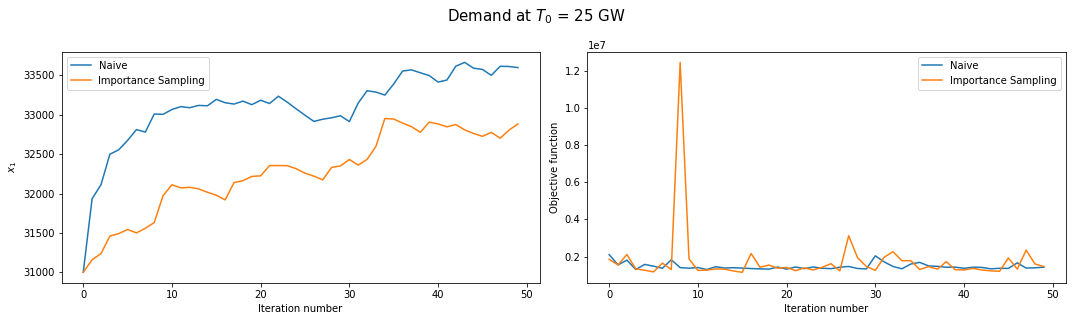

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


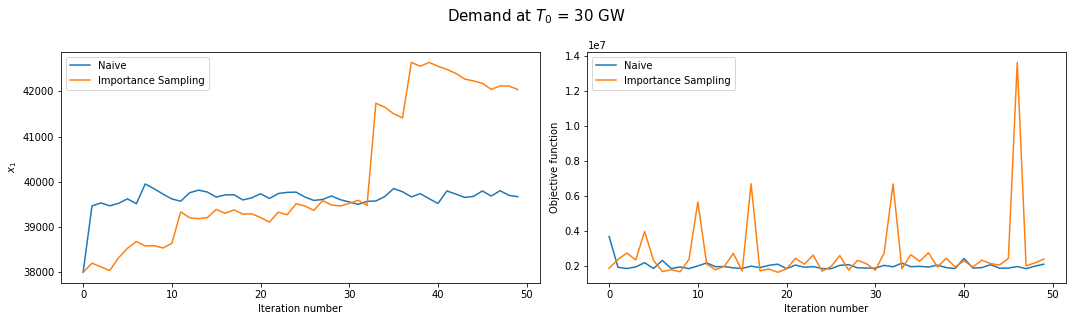

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


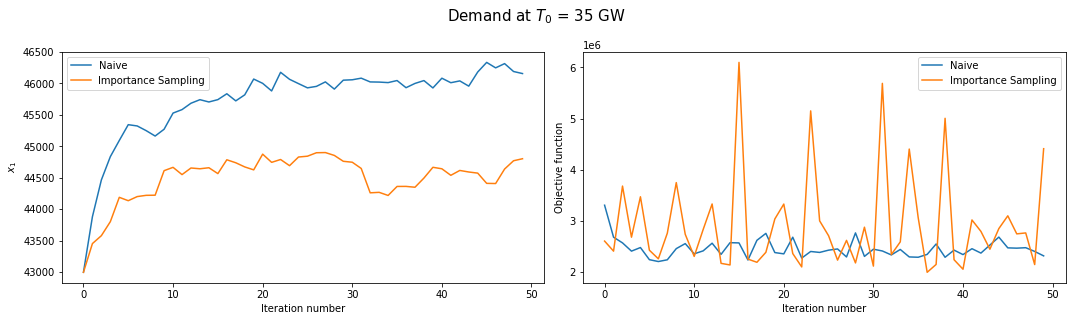



*****   TESTING THE SOLUTIONS   *****


Demand at t0: 25GWH

After 5 training episodes: 
Naive:     	x1: 32555.18134124577	Mean objective: 1447165.8783395095 
Importance:	x1: 31491.56218301505	Mean objective: 1680651.5664171784

After 10 training episodes: 
Naive:     	x1: 33005.65508566797	Mean objective: 1421786.8104751338 
Importance:	x1: 31973.296468146145	Mean objective: 1537536.2470327148

After 20 training episodes: 
Naive:     	x1: 33128.119696862996	Mean objective: 1419501.333273832 
Importance:	x1: 32217.385288327932	Mean objective: 1490719.220911826

After 50 training episodes: 
Naive:     	x1: 33598.820719867945	Mean objective: 1422364.6512598332 
Importance:	x1: 32882.90106598288	Mean objective: 1425752.853587417


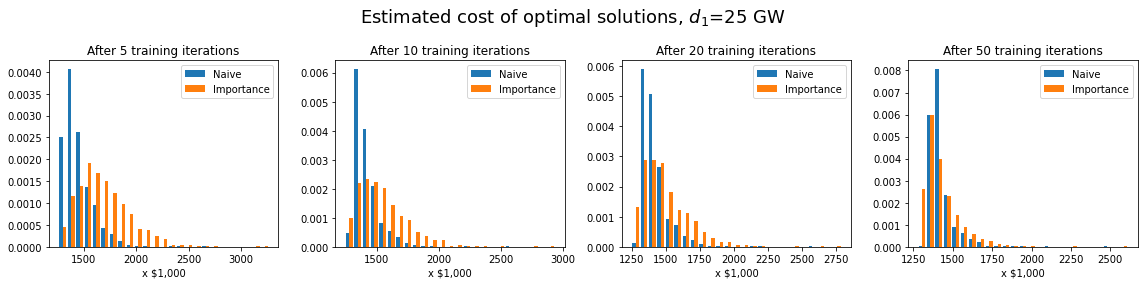


Demand at t0: 30GWH

After 5 training episodes: 
Naive:     	x1: 39524.16084893048	Mean objective: 1953953.463498818 
Importance:	x1: 38321.84750307351	Mean objective: 2191475.985569541

After 10 training episodes: 
Naive:     	x1: 39728.36158890277	Mean objective: 1948437.747088302 
Importance:	x1: 38537.539715878665	Mean objective: 2108895.1881918022

After 20 training episodes: 
Naive:     	x1: 39644.66863498092	Mean objective: 1949987.7338945952 
Importance:	x1: 39292.41356626153	Mean objective: 1967839.032470899

After 50 training episodes: 
Naive:     	x1: 39671.1704665795	Mean objective: 1949385.1166747385 
Importance:	x1: 42037.60315384716	Mean objective: 2103887.7611674108


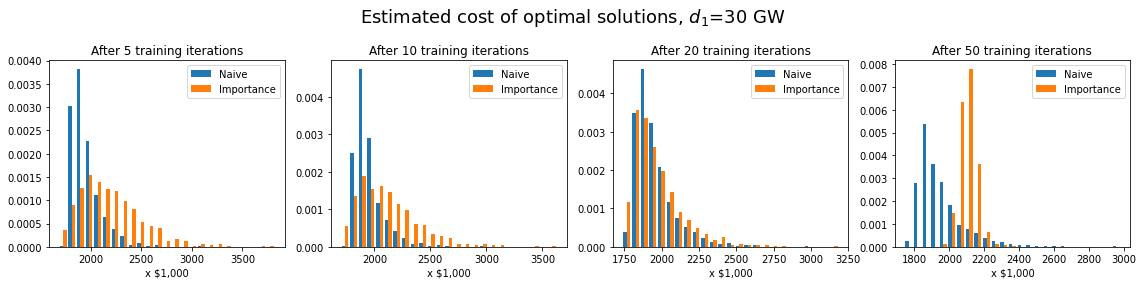


Demand at t0: 35GWH

After 5 training episodes: 
Naive:     	x1: 45094.63573992252	Mean objective: 2522871.4673717814 
Importance:	x1: 44191.25843048096	Mean objective: 2769587.2887661257

After 10 training episodes: 
Naive:     	x1: 45272.95188233256	Mean objective: 2496111.7185881287 
Importance:	x1: 44614.82882685959	Mean objective: 2627364.21200113

After 20 training episodes: 
Naive:     	x1: 46070.38053870201	Mean objective: 2441718.3451437033 
Importance:	x1: 44627.49690935016	Mean objective: 2623907.3235123158

After 50 training episodes: 
Naive:     	x1: 46157.7586196363	Mean objective: 2440773.6438642484 
Importance:	x1: 44804.47043385357	Mean objective: 2579689.0227668285


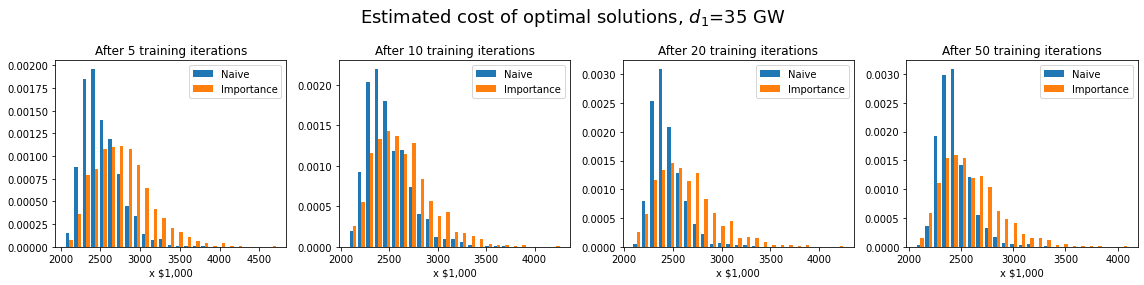

In [37]:
results, comparisons = train_and_test(
    x1_start_diffs = [6000, 8000, 8000],
    **train_test_args
)

Importance sampling doesn't seem to do too well. How does it compare if we use smaller sample sizes?

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.70it/s]


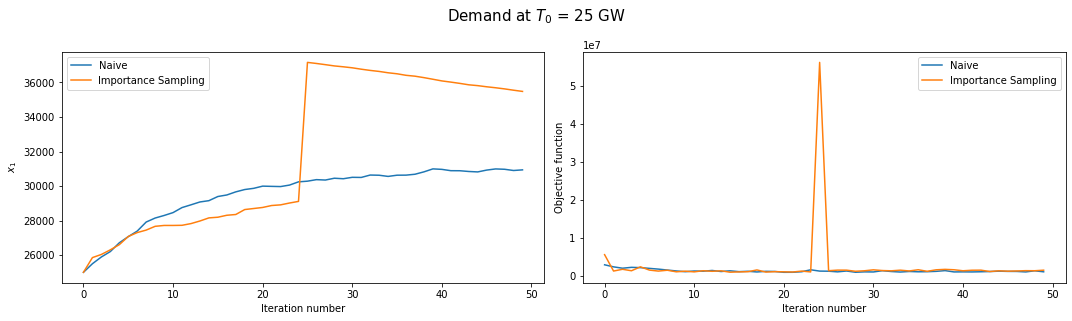

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.74it/s]


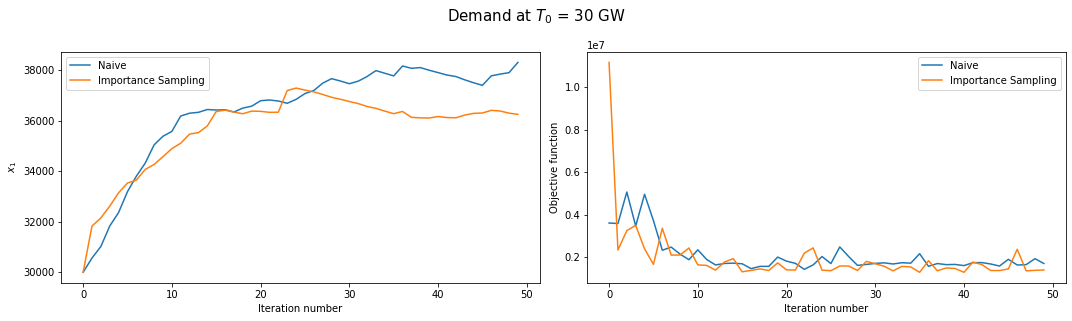

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.77it/s]


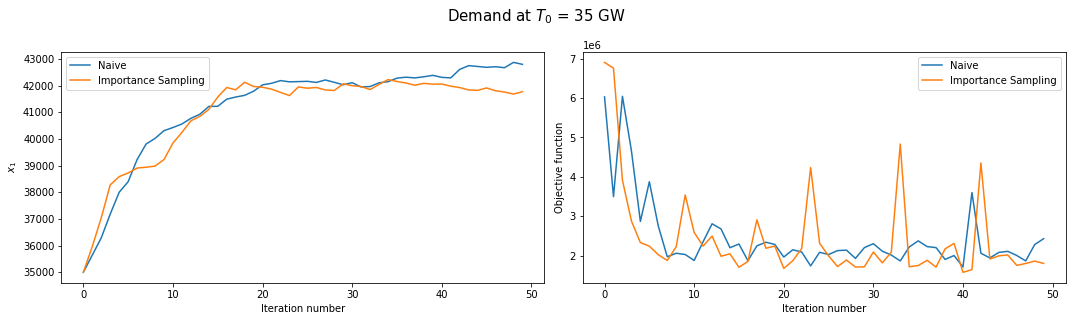



*****   TESTING THE SOLUTIONS   *****


Demand at t0: 25GWH

After 5 training episodes: 
Naive:     	x1: 26708.936179056764	Mean objective: 1996415.5323448302 
Importance:	x1: 26600.893447175622	Mean objective: 2034325.194626659

After 10 training episodes: 
Naive:     	x1: 28292.376059107482	Mean objective: 1534252.2781330233 
Importance:	x1: 27715.18575027585	Mean objective: 1679327.4840422168

After 20 training episodes: 
Naive:     	x1: 29865.890834480524	Mean objective: 1299038.877458003 
Importance:	x1: 28696.634783409536	Mean objective: 1451381.7781924673

After 50 training episodes: 
Naive:     	x1: 30935.69059856236	Mean objective: 1259670.5192646075 
Importance:	x1: 35481.98505304754	Mean objective: 1524020.5718736844


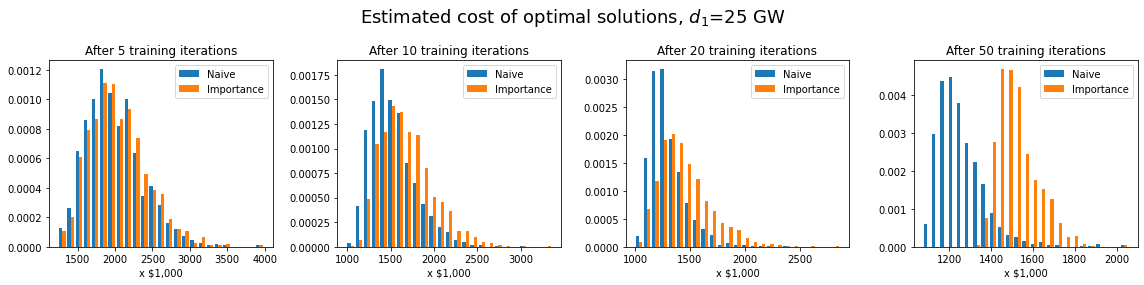


Demand at t0: 30GWH

After 5 training episodes: 
Naive:     	x1: 32369.70605328679	Mean objective: 3633364.887959231 
Importance:	x1: 33149.83446151018	Mean objective: 3159407.8736229534

After 10 training episodes: 
Naive:     	x1: 35389.05733264983	Mean objective: 2133229.508638651 
Importance:	x1: 34581.38366229832	Mean objective: 2434822.306984479

After 20 training episodes: 
Naive:     	x1: 36580.72717487812	Mean objective: 1846203.5477297339 
Importance:	x1: 36385.71102172136	Mean objective: 1880266.0793300644

After 50 training episodes: 
Naive:     	x1: 38314.899168908596	Mean objective: 1752011.1486613653 
Importance:	x1: 36256.29466958344	Mean objective: 1905683.7961500555


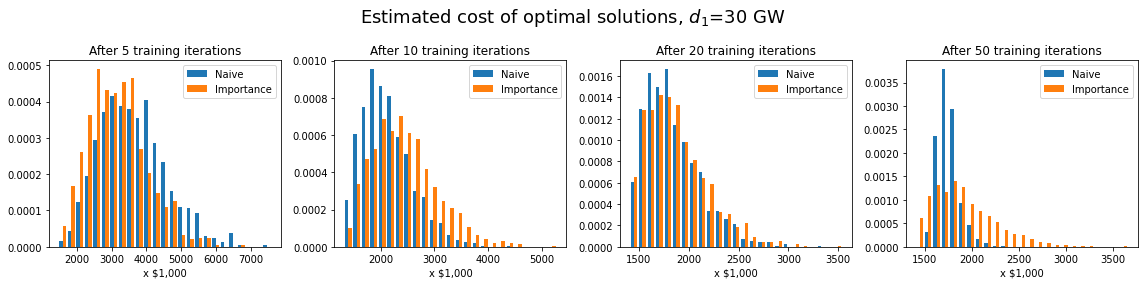


Demand at t0: 35GWH

After 5 training episodes: 
Naive:     	x1: 38000.51923841238	Mean objective: 3288040.430766842 
Importance:	x1: 38585.864789783955	Mean objective: 2994848.1853243466

After 10 training episodes: 
Naive:     	x1: 40310.567328706384	Mean objective: 2403879.6381949238 
Importance:	x1: 39226.860823109746	Mean objective: 2733027.3738758587

After 20 training episodes: 
Naive:     	x1: 41790.736108087	Mean objective: 2158419.033900894 
Importance:	x1: 41967.9943844676	Mean objective: 2143518.0781470924

After 50 training episodes: 
Naive:     	x1: 42796.83771543205	Mean objective: 2109411.6959118308 
Importance:	x1: 41772.13817834854	Mean objective: 2160153.0094595016


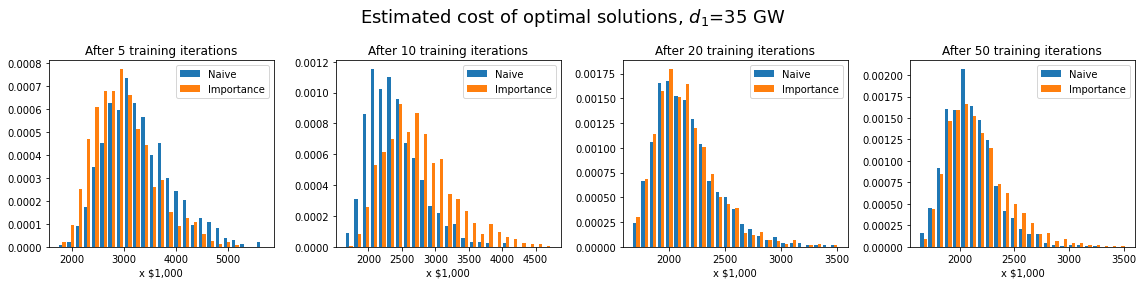

In [38]:
train_test_args["n"] = 10
results, comparisons = train_and_test(**train_test_args)

## Conclusion

While importance sampling (IS) may work better in cases where rare but high-impact discrete events can fail to be sampled using the naive approach (NS), for the current application Dantzig and Glynn's proposal often seems to fail miserably. 

Perhaps this is because, in our application, we concern ourselves with continuous distributions whose extremes are not that extreme at all:  
- the Normal distribution, which we used to model conditional demand, ensures that there is only an infinitesimal probability of events further than 5-6 standard deviations away from the mean
- the bootstrap distributions we used to model unit costs also produce values that are always more-or-less of the same scale, so there is less scope for nasty surprises against which the model needs to hedge  

Also, as the problem is stated, we do not have to contend with second-stage feasibility issues, which IS should be quicker than NS to bring up.

Moreover, Dantzig and Glynn proposed IS over thirty years ago, at a time when computing power was much more expensive than it is today. In the context of the early 1990's, an approach that could come up with a reasonable solution using relatively small sample sizes thus had a clearer value than it does today, now that including rare events in a sample can be accomplished by cheaply increasing the sample size. Indeed, when we compared NS and IS using smaller sample sizes, we saw that IS appears to have a slight edge over NS, especially in the first few iterations of the optimization procedure.  

However, this edge broke down as the overall sample size grew and the greater variance of the IS distribution we used prevented the algorithm from converging towards a stable value (which NS eventually managed to do). Nowadays, one may be better off simply increasing the sample size, rather than layering some finicky synthetic distribution into the sampling procedure.